# 🛠 Install Libraries

In [1]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
!pip install -q scikit-learn==1.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 1.0 which is incompatible.
featuretools 1.6.0 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.


# 📚 Import Libraries 

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
import math
import wandb

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.utils.data import Dataset
import segmentation_models_pytorch
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

# OpenCV
import cv2
from cv2 import imread, createCLAHE 

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [3]:
class CFG:
    seed          = 2022
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-224x224'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 40
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 500
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_fold        = 5
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Dataset Generation

In [4]:
class BuildDataset(Dataset):
    def __init__(self, img_path, mask_path, label, transforms):
        length = 0
        img_paths = []
        mask_paths = []
        img_path_list = os.listdir(img_path)
        len_list = len(img_path_list)
        if label == "train":
            img_path_list = img_path_list[0:round(0.8*len_list)]
        if label == "valid":
            img_path_list = img_path_list[round(0.8*len_list)+1:round(1*len_list)]
        for i in img_path_list:
            for j in os.listdir(os.path.join(img_path,i)):      
                length = length + 1
                img_paths.append(os.path.join(img_path,i,j))
                mask_paths.append(os.path.join(mask_path,i,j))
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.length = length
        self.transforms = transforms[label]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        img_path  = "".join(self.img_paths[index])
        img = cv2.imread(img_path)[:,:,0]
        img = img.astype('float32') # original is uint16     
        mask_path = "".join(self.mask_paths[index])
        mask = cv2.imread(mask_path)[:,:,0]
        mask = mask.astype('float32') # original is uint16    
        data = self.transforms(image=img, mask=mask)
        img  = data['image']
        mask  = data['mask']
        return img, mask
    
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size),
        ToTensorV2()], p=1.0)
}

# 📈 Visualization

In [5]:
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,].numpy()
        img = img.astype('uint8')
        msk = msks[idx,].numpy()
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()

# 📦 Model

In [6]:
def build_model():
    model = segmentation_models_pytorch.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def fetch_scheduler(optimizer, mode):
    if mode == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif mode == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif mode == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif mode == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif mode == None:
        return None
        
    return scheduler

model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer,CFG.scheduler)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

# ⭐ WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

In [7]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB")
wandb.login(key=api_key)
anonymous = None

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 🔧 Loss Function

In [8]:
#JaccardLoss = segmentation_models_pytorch.losses.JaccardLoss(mode='binary')
DiceLoss    = segmentation_models_pytorch.losses.DiceLoss(mode='binary')
BCELoss     = segmentation_models_pytorch.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = segmentation_models_pytorch.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss = segmentation_models_pytorch.losses.TverskyLoss(mode='binary', log_loss=False, alpha = 0.95, beta = 0.05)

def dice_coef(y_true, y_pred, thr=0.95, epsilon=0.001):
    y_true = (y_true>thr).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = torch.sum(y_true*y_pred)
    den = torch.sum(y_true) + torch.sum(y_pred)
    dice = ((2*inter+epsilon)/(den+epsilon))
    return dice

def iou_coef(y_true, y_pred, thr=0.95, epsilon=0.001):
    y_true = (y_true>thr).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = torch.sum(y_true*y_pred)
    union = torch.sum(y_true + y_pred - y_true*y_pred)
    iou = ((inter+epsilon)/(union+epsilon))
    return iou



def criterion(y_pred, y_true):
#    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)
#    return 0.1*DiceLoss(y_pred, y_true) + 0.9*JaccardLoss(y_pred, y_true)
    return TverskyLoss(y_pred, y_true)


# 🚅 Training

train_image, train_mask = next(iter(train_dataset_loader))
train_image = train_image.to(CFG.device, dtype=torch.float)
y_pred = model(train_image)
y_pred_1 = y_pred.cpu()
y_pred_2 = y_pred_1.detach().numpy()
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,]
        img = img.astype('uint8')
        msk = msks[idx,].numpy()
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_batch(y_pred_2.squeeze(1), train_mask.squeeze(1), 25, 5)
BCELoss = segmentation_models_pytorch.losses.SoftBCEWithLogitsLoss()
TverskyLoss = segmentation_models_pytorch.losses.TverskyLoss(mode='multilabel', log_loss=False)
loss = 0.5*BCELoss(y_pred.squeeze(1), train_mask) + 0.5*TverskyLoss(y_pred.squeeze(1), train_mask)
rain_mask = train_mask.to(CFG.device, dtype=torch.float)
torch.cuda.empty_cache()

In [9]:
img_path = "../input/cbct-cut-relax/CT_tif_cut"
mask_path = "../input/cbct-cut-relax/GT_tif_cut"
train_dataset = BuildDataset(img_path, mask_path,"train",data_transforms)
train_dataset_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
valid_dataset = BuildDataset(img_path, mask_path,"valid",data_transforms)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=4, shuffle=False, pin_memory=True) 
run = wandb.init(project='tooth segmentatio',config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},anonymous=anonymous,name=f"fold-|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",group=CFG.comment,)
if torch.cuda.is_available():
    print("cuda: {}\n".format(torch.cuda.get_device_name()))
start = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_dice = -np.inf
best_epoch = -1
history = defaultdict(list) # store data values like a map

wandb: Currently logged in as: benxiang-jiang. Use `wandb login --relogin` to force relogin


cuda: Tesla P100-PCIE-16GB



In [10]:
for epoch in range(1, CFG.epochs + 1): 
    gc.collect() #clear variables and objects
    print(f'Epoch {epoch}/{CFG.epochs}', end='')
    # train one epoch
    model.train() #open batch normalization and drop out
    scaler = amp.GradScaler() #automatic mixed precision for scaler; help perform the steps of gradient scaling conveniently
    train_scores = []
    dataset_size = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(train_dataset_loader), total=len(train_dataset_loader), desc='Train') # show progress #enumerate dataloader
    for step, (images, masks) in pbar:
        with amp.autocast(enabled=True): #automatic mixed precision for tensor; 不清楚为啥用with，但是先学吧
            images = images.to(CFG.device, dtype=torch.float)
            masks  = masks.to(CFG.device, dtype=torch.float)
            #batch_size = images.size(0)
            y_pred = model(images).squeeze(1)
            loss = criterion(y_pred, masks)
            scaler.scale(loss).backward() #normalization and backward propagation
            scaler.step(optimizer)
            scaler.update() #update parameters
            optimizer.zero_grad() # zero the parameter gradients
            scheduler.step() #change learning rate with scheduler
            #running_loss += (loss.item() * zz)
            #dataset_size += batch_size
            #train_loss = running_loss / dataset_size
            train_loss = loss.item()
            train_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
            train_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
            train_scores.append([train_dice, train_jaccard])
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_loss=f'{train_loss:0.4f}',lr=f'{current_lr:0.5f}',gpu_mem=f'{mem:0.2f} GB')
    train_scores  = np.mean(train_scores, axis=0)
    train_dice, train_jaccard = train_scores
    torch.cuda.empty_cache()
    gc.collect()
    # valid one epoch
    with torch.no_grad(): #turn off gradients computation
        model.eval() #close batch normalization and drop out
        dataset_size = 0
        running_loss = 0.
        val_scores = []
        pbar = tqdm(enumerate(valid_dataset_loader), total=len(valid_dataset_loader), desc='Valid') # show progress #enumerate dataloader
        for step, (images, masks) in pbar:
            images = images.to(CFG.device, dtype=torch.float)
            masks  = masks.to(CFG.device, dtype=torch.float)
            #batch_size = images.size(0)
            y_pred = model(images).squeeze(1)
            loss = criterion(y_pred, masks)
            #running_loss += (loss.item() * batch_size)
            #dataset_size += batch_size
            #val_loss = running_loss / dataset_size
            val_loss = loss.item()
            y_pred = nn.Sigmoid()(y_pred)
            val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
            val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
            val_scores.append([val_dice, val_jaccard])
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(val_loss=f'{val_loss:0.4f}',lr=f'{current_lr:0.5f}',gpu_mem=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    val_dice, val_jaccard = val_scores
    
    # history
    history['Train Loss'].append(train_loss)
    history['Valid Loss'].append(val_loss)
    history['Train Dice'].append(train_dice)
    history['Train Jaccard'].append(train_jaccard)
    history['Valid Dice'].append(val_dice)
    history['Valid Jaccard'].append(val_jaccard)
    
    # Log the metrics
    #wandb.log({"Train Loss": train_loss,"Valid Loss": val_loss,"Valid Dice": val_dice,"Valid Jaccard": val_jaccard,"LR":scheduler.get_last_lr()[0]})
    print(f'Train Dice: {train_dice:0.4f} |Train Jaccard: {train_jaccard:0.4f} |Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
    
    # deep copy the model
    if val_dice >= best_dice:
        print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
        best_dice    = val_dice
        best_jaccard = val_jaccard
        best_epoch   = epoch
        run.summary["Best Dice"]    = best_dice
        run.summary["Best Jaccard"] = best_jaccard
        run.summary["Best Epoch"]   = best_epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"best_epoch.bin"
        torch.save(model.state_dict(), PATH)
        # Save a model file from the current directory
        wandb.save(PATH)
        print(f"Model Saved{sr_}")
    last_model_wts = copy.deepcopy(model.state_dict())
    PATH = f"last_epoch.bin"
    torch.save(model.state_dict(), PATH)
    print(); print()

# end training
end = time.time()
time_elapsed = end - start
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print("Best Score: {:.4f}".format(best_jaccard))

# load best model weights
model.load_state_dict(best_model_wts)

#run.finish()
display(ipd.IFrame(run.url, width=1000, height=720))

Epoch 1/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s, gpu_mem=2.99 GB, lr=0.00200, val_loss=-13.5806]


Train Dice: 0.5009 |Train Jaccard: 0.3666 |Valid Dice: 0.4449 | Valid Jaccard: 0.2862
Valid Score Improved (-inf ---> 0.4449)
Model Saved


Epoch 2/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.0674]


Train Dice: 0.7880 |Train Jaccard: 0.6511 |Valid Dice: 0.7935 | Valid Jaccard: 0.6577
Valid Score Improved (0.4449 ---> 0.7935)
Model Saved


Epoch 3/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.11 GB, lr=0.00200, val_loss=-16.1599]


Train Dice: 0.8168 |Train Jaccard: 0.6920 |Valid Dice: 0.7358 | Valid Jaccard: 0.5821


Epoch 4/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.4579]


Train Dice: 0.8262 |Train Jaccard: 0.7048 |Valid Dice: 0.8713 | Valid Jaccard: 0.7720
Valid Score Improved (0.7935 ---> 0.8713)
Model Saved


Epoch 5/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.6487]


Train Dice: 0.8375 |Train Jaccard: 0.7210 |Valid Dice: 0.8542 | Valid Jaccard: 0.7456


Epoch 6/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.7502]


Train Dice: 0.8425 |Train Jaccard: 0.7288 |Valid Dice: 0.8741 | Valid Jaccard: 0.7764
Valid Score Improved (0.8713 ---> 0.8741)
Model Saved


Epoch 7/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.7693]


Train Dice: 0.8440 |Train Jaccard: 0.7311 |Valid Dice: 0.8724 | Valid Jaccard: 0.7737


Epoch 8/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8082]


Train Dice: 0.8470 |Train Jaccard: 0.7352 |Valid Dice: 0.8767 | Valid Jaccard: 0.7804
Valid Score Improved (0.8741 ---> 0.8767)
Model Saved


Epoch 9/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.7773]


Train Dice: 0.8536 |Train Jaccard: 0.7453 |Valid Dice: 0.8853 | Valid Jaccard: 0.7942
Valid Score Improved (0.8767 ---> 0.8853)
Model Saved


Epoch 10/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.8127]


Train Dice: 0.8527 |Train Jaccard: 0.7440 |Valid Dice: 0.8760 | Valid Jaccard: 0.7794


Epoch 11/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.9489]


Train Dice: 0.8658 |Train Jaccard: 0.7640 |Valid Dice: 0.8848 | Valid Jaccard: 0.7934


Epoch 12/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.09 GB, lr=0.00200, val_loss=-16.9999]


Train Dice: 0.8698 |Train Jaccard: 0.7703 |Valid Dice: 0.8684 | Valid Jaccard: 0.7675


Epoch 13/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.9683]


Train Dice: 0.8656 |Train Jaccard: 0.7638 |Valid Dice: 0.8665 | Valid Jaccard: 0.7644


Epoch 14/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.09 GB, lr=0.00200, val_loss=-16.3921]


Train Dice: 0.8749 |Train Jaccard: 0.7780 |Valid Dice: 0.8787 | Valid Jaccard: 0.7837


Epoch 15/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.5473]


Train Dice: 0.8706 |Train Jaccard: 0.7716 |Valid Dice: 0.9040 | Valid Jaccard: 0.8248
Valid Score Improved (0.8853 ---> 0.9040)
Model Saved


Epoch 16/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9729]


Train Dice: 0.8739 |Train Jaccard: 0.7767 |Valid Dice: 0.8719 | Valid Jaccard: 0.7729


Epoch 17/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9465]


Train Dice: 0.8753 |Train Jaccard: 0.7789 |Valid Dice: 0.8683 | Valid Jaccard: 0.7673


Epoch 18/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9926]


Train Dice: 0.8794 |Train Jaccard: 0.7851 |Valid Dice: 0.8732 | Valid Jaccard: 0.7749


Epoch 19/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0165]


Train Dice: 0.8806 |Train Jaccard: 0.7873 |Valid Dice: 0.8859 | Valid Jaccard: 0.7952


Epoch 20/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9052]


Train Dice: 0.8829 |Train Jaccard: 0.7908 |Valid Dice: 0.9149 | Valid Jaccard: 0.8431
Valid Score Improved (0.9040 ---> 0.9149)
Model Saved


Epoch 21/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.09 GB, lr=0.00200, val_loss=-16.9855]


Train Dice: 0.8841 |Train Jaccard: 0.7929 |Valid Dice: 0.8884 | Valid Jaccard: 0.7992


Epoch 22/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0415]


Train Dice: 0.8853 |Train Jaccard: 0.7945 |Valid Dice: 0.8967 | Valid Jaccard: 0.8128


Epoch 23/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0450]


Train Dice: 0.8855 |Train Jaccard: 0.7949 |Valid Dice: 0.8887 | Valid Jaccard: 0.7997


Epoch 24/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0065]


Train Dice: 0.8845 |Train Jaccard: 0.7934 |Valid Dice: 0.8935 | Valid Jaccard: 0.8076


Epoch 25/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8034]


Train Dice: 0.8862 |Train Jaccard: 0.7959 |Valid Dice: 0.9002 | Valid Jaccard: 0.8186


Epoch 26/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0155]


Train Dice: 0.8869 |Train Jaccard: 0.7973 |Valid Dice: 0.8989 | Valid Jaccard: 0.8163


Epoch 27/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9888]


Train Dice: 0.8884 |Train Jaccard: 0.7995 |Valid Dice: 0.8953 | Valid Jaccard: 0.8105


Epoch 28/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0394]


Train Dice: 0.8914 |Train Jaccard: 0.8045 |Valid Dice: 0.8935 | Valid Jaccard: 0.8074


Epoch 29/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0175]


Train Dice: 0.8844 |Train Jaccard: 0.7933 |Valid Dice: 0.8893 | Valid Jaccard: 0.8007


Epoch 30/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9958]


Train Dice: 0.8846 |Train Jaccard: 0.7935 |Valid Dice: 0.8980 | Valid Jaccard: 0.8149


Epoch 31/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0076]


Train Dice: 0.8859 |Train Jaccard: 0.7958 |Valid Dice: 0.8986 | Valid Jaccard: 0.8159


Epoch 32/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0416]


Train Dice: 0.8874 |Train Jaccard: 0.7979 |Valid Dice: 0.8609 | Valid Jaccard: 0.7557


Epoch 33/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8138]


Train Dice: 0.8869 |Train Jaccard: 0.7972 |Valid Dice: 0.9015 | Valid Jaccard: 0.8206


Epoch 34/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9135]


Train Dice: 0.8905 |Train Jaccard: 0.8028 |Valid Dice: 0.9118 | Valid Jaccard: 0.8380


Epoch 35/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0455]


Train Dice: 0.8866 |Train Jaccard: 0.7968 |Valid Dice: 0.9000 | Valid Jaccard: 0.8182


Epoch 36/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0715]


Train Dice: 0.8884 |Train Jaccard: 0.7997 |Valid Dice: 0.8929 | Valid Jaccard: 0.8065


Epoch 37/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0631]


Train Dice: 0.8921 |Train Jaccard: 0.8054 |Valid Dice: 0.8798 | Valid Jaccard: 0.7855


Epoch 38/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0428]


Train Dice: 0.8922 |Train Jaccard: 0.8056 |Valid Dice: 0.8685 | Valid Jaccard: 0.7677


Epoch 39/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9513]


Train Dice: 0.8929 |Train Jaccard: 0.8068 |Valid Dice: 0.9134 | Valid Jaccard: 0.8406


Epoch 40/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9539]


Train Dice: 0.8943 |Train Jaccard: 0.8091 |Valid Dice: 0.9133 | Valid Jaccard: 0.8405


Epoch 41/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9398]


Train Dice: 0.8948 |Train Jaccard: 0.8099 |Valid Dice: 0.9170 | Valid Jaccard: 0.8468
Valid Score Improved (0.9149 ---> 0.9170)
Model Saved


Epoch 42/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0386]


Train Dice: 0.8932 |Train Jaccard: 0.8074 |Valid Dice: 0.9036 | Valid Jaccard: 0.8241


Epoch 43/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0125]


Train Dice: 0.8954 |Train Jaccard: 0.8109 |Valid Dice: 0.9030 | Valid Jaccard: 0.8232


Epoch 44/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.9422]


Train Dice: 0.8968 |Train Jaccard: 0.8131 |Valid Dice: 0.9169 | Valid Jaccard: 0.8465


Epoch 45/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-16.9515]


Train Dice: 0.8935 |Train Jaccard: 0.8077 |Valid Dice: 0.9031 | Valid Jaccard: 0.8234


Epoch 46/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0181]


Train Dice: 0.8952 |Train Jaccard: 0.8104 |Valid Dice: 0.9087 | Valid Jaccard: 0.8326


Epoch 47/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-17.0389]


Train Dice: 0.8949 |Train Jaccard: 0.8100 |Valid Dice: 0.9048 | Valid Jaccard: 0.8261


Epoch 48/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.08 GB, lr=0.00200, val_loss=-17.0073]


Train Dice: 0.8920 |Train Jaccard: 0.8055 |Valid Dice: 0.9073 | Valid Jaccard: 0.8304


Epoch 49/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0450]


Train Dice: 0.8952 |Train Jaccard: 0.8105 |Valid Dice: 0.8950 | Valid Jaccard: 0.8100


Epoch 50/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9496]


Train Dice: 0.8931 |Train Jaccard: 0.8072 |Valid Dice: 0.8989 | Valid Jaccard: 0.8164


Epoch 51/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9047]


Train Dice: 0.8944 |Train Jaccard: 0.8093 |Valid Dice: 0.9199 | Valid Jaccard: 0.8516
Valid Score Improved (0.9170 ---> 0.9199)
Model Saved


Epoch 52/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9036]


Train Dice: 0.8947 |Train Jaccard: 0.8097 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 53/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9816]


Train Dice: 0.8951 |Train Jaccard: 0.8103 |Valid Dice: 0.9165 | Valid Jaccard: 0.8459


Epoch 54/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0151]


Train Dice: 0.8957 |Train Jaccard: 0.8114 |Valid Dice: 0.9122 | Valid Jaccard: 0.8386


Epoch 55/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0213]


Train Dice: 0.8960 |Train Jaccard: 0.8118 |Valid Dice: 0.9133 | Valid Jaccard: 0.8404


Epoch 56/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0452]


Train Dice: 0.8981 |Train Jaccard: 0.8153 |Valid Dice: 0.9020 | Valid Jaccard: 0.8215


Epoch 57/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0420]


Train Dice: 0.8969 |Train Jaccard: 0.8133 |Valid Dice: 0.9039 | Valid Jaccard: 0.8247


Epoch 58/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9933]


Train Dice: 0.8986 |Train Jaccard: 0.8161 |Valid Dice: 0.9101 | Valid Jaccard: 0.8351


Epoch 59/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0396]


Train Dice: 0.8949 |Train Jaccard: 0.8101 |Valid Dice: 0.9036 | Valid Jaccard: 0.8241


Epoch 60/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9754]


Train Dice: 0.8965 |Train Jaccard: 0.8127 |Valid Dice: 0.9157 | Valid Jaccard: 0.8446


Epoch 61/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9530]


Train Dice: 0.8957 |Train Jaccard: 0.8114 |Valid Dice: 0.9166 | Valid Jaccard: 0.8460


Epoch 62/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0043]


Train Dice: 0.8958 |Train Jaccard: 0.8113 |Valid Dice: 0.9084 | Valid Jaccard: 0.8321


Epoch 63/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0684]


Train Dice: 0.8940 |Train Jaccard: 0.8085 |Valid Dice: 0.8962 | Valid Jaccard: 0.8120


Epoch 64/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0648]


Train Dice: 0.8953 |Train Jaccard: 0.8108 |Valid Dice: 0.8950 | Valid Jaccard: 0.8099


Epoch 65/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0612]


Train Dice: 0.8955 |Train Jaccard: 0.8110 |Valid Dice: 0.9031 | Valid Jaccard: 0.8234


Epoch 66/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0274]


Train Dice: 0.8982 |Train Jaccard: 0.8154 |Valid Dice: 0.9059 | Valid Jaccard: 0.8280


Epoch 67/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0233]


Train Dice: 0.8960 |Train Jaccard: 0.8118 |Valid Dice: 0.9076 | Valid Jaccard: 0.8309


Epoch 68/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0459]


Train Dice: 0.8981 |Train Jaccard: 0.8152 |Valid Dice: 0.9097 | Valid Jaccard: 0.8344


Epoch 69/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0442]


Train Dice: 0.8969 |Train Jaccard: 0.8133 |Valid Dice: 0.9058 | Valid Jaccard: 0.8278


Epoch 70/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0133]


Train Dice: 0.8980 |Train Jaccard: 0.8151 |Valid Dice: 0.9144 | Valid Jaccard: 0.8423


Epoch 71/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9757]


Train Dice: 0.8996 |Train Jaccard: 0.8177 |Valid Dice: 0.9201 | Valid Jaccard: 0.8521
Valid Score Improved (0.9199 ---> 0.9201)
Model Saved


Epoch 72/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0607]


Train Dice: 0.8966 |Train Jaccard: 0.8128 |Valid Dice: 0.9074 | Valid Jaccard: 0.8305


Epoch 73/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0158]


Train Dice: 0.8914 |Train Jaccard: 0.8052 |Valid Dice: 0.9056 | Valid Jaccard: 0.8276


Epoch 74/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9822]


Train Dice: 0.8959 |Train Jaccard: 0.8117 |Valid Dice: 0.9175 | Valid Jaccard: 0.8475


Epoch 75/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0663]


Train Dice: 0.8990 |Train Jaccard: 0.8168 |Valid Dice: 0.9005 | Valid Jaccard: 0.8191


Epoch 76/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0758]


Train Dice: 0.8972 |Train Jaccard: 0.8138 |Valid Dice: 0.8978 | Valid Jaccard: 0.8145


Epoch 77/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0560]


Train Dice: 0.9001 |Train Jaccard: 0.8184 |Valid Dice: 0.8962 | Valid Jaccard: 0.8120


Epoch 78/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0534]


Train Dice: 0.8994 |Train Jaccard: 0.8174 |Valid Dice: 0.9122 | Valid Jaccard: 0.8386


Epoch 79/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0616]


Train Dice: 0.9001 |Train Jaccard: 0.8186 |Valid Dice: 0.9044 | Valid Jaccard: 0.8256


Epoch 80/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0796]


Train Dice: 0.8997 |Train Jaccard: 0.8179 |Valid Dice: 0.9140 | Valid Jaccard: 0.8416


Epoch 81/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0741]


Train Dice: 0.8989 |Train Jaccard: 0.8165 |Valid Dice: 0.9091 | Valid Jaccard: 0.8333


Epoch 82/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9997]


Train Dice: 0.8971 |Train Jaccard: 0.8137 |Valid Dice: 0.8921 | Valid Jaccard: 0.8053


Epoch 83/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0177]


Train Dice: 0.8968 |Train Jaccard: 0.8130 |Valid Dice: 0.9005 | Valid Jaccard: 0.8191


Epoch 84/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0199]


Train Dice: 0.8962 |Train Jaccard: 0.8122 |Valid Dice: 0.9081 | Valid Jaccard: 0.8317


Epoch 85/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0411]


Train Dice: 0.8969 |Train Jaccard: 0.8132 |Valid Dice: 0.9040 | Valid Jaccard: 0.8248


Epoch 86/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0090]


Train Dice: 0.9002 |Train Jaccard: 0.8186 |Valid Dice: 0.9115 | Valid Jaccard: 0.8374


Epoch 87/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0594]


Train Dice: 0.9000 |Train Jaccard: 0.8183 |Valid Dice: 0.8960 | Valid Jaccard: 0.8116


Epoch 88/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0549]


Train Dice: 0.8987 |Train Jaccard: 0.8164 |Valid Dice: 0.8961 | Valid Jaccard: 0.8117


Epoch 89/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0431]


Train Dice: 0.8989 |Train Jaccard: 0.8165 |Valid Dice: 0.9037 | Valid Jaccard: 0.8243


Epoch 90/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0684]


Train Dice: 0.8954 |Train Jaccard: 0.8108 |Valid Dice: 0.8889 | Valid Jaccard: 0.8000


Epoch 91/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0815]


Train Dice: 0.8921 |Train Jaccard: 0.8063 |Valid Dice: 0.8854 | Valid Jaccard: 0.7944


Epoch 92/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0392]


Train Dice: 0.8947 |Train Jaccard: 0.8097 |Valid Dice: 0.8950 | Valid Jaccard: 0.8100


Epoch 93/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9980]


Train Dice: 0.9002 |Train Jaccard: 0.8186 |Valid Dice: 0.9091 | Valid Jaccard: 0.8333


Epoch 94/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0545]


Train Dice: 0.9009 |Train Jaccard: 0.8198 |Valid Dice: 0.8986 | Valid Jaccard: 0.8158


Epoch 95/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0363]


Train Dice: 0.8979 |Train Jaccard: 0.8150 |Valid Dice: 0.9099 | Valid Jaccard: 0.8348


Epoch 96/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0261]


Train Dice: 0.8987 |Train Jaccard: 0.8162 |Valid Dice: 0.9140 | Valid Jaccard: 0.8416


Epoch 97/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0980]


Train Dice: 0.9029 |Train Jaccard: 0.8232 |Valid Dice: 0.8955 | Valid Jaccard: 0.8108


Epoch 98/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0770]


Train Dice: 0.9002 |Train Jaccard: 0.8187 |Valid Dice: 0.9020 | Valid Jaccard: 0.8215


Epoch 99/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0473]


Train Dice: 0.9000 |Train Jaccard: 0.8184 |Valid Dice: 0.9089 | Valid Jaccard: 0.8331


Epoch 100/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0088]


Train Dice: 0.8979 |Train Jaccard: 0.8150 |Valid Dice: 0.8877 | Valid Jaccard: 0.7981


Epoch 101/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0094]


Train Dice: 0.8979 |Train Jaccard: 0.8150 |Valid Dice: 0.9147 | Valid Jaccard: 0.8427


Epoch 102/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0699]


Train Dice: 0.9003 |Train Jaccard: 0.8189 |Valid Dice: 0.9077 | Valid Jaccard: 0.8311


Epoch 103/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9457]


Train Dice: 0.9019 |Train Jaccard: 0.8215 |Valid Dice: 0.9192 | Valid Jaccard: 0.8504


Epoch 104/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0081]


Train Dice: 0.8989 |Train Jaccard: 0.8166 |Valid Dice: 0.8898 | Valid Jaccard: 0.8015


Epoch 105/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9503]


Train Dice: 0.8978 |Train Jaccard: 0.8149 |Valid Dice: 0.9022 | Valid Jaccard: 0.8219


Epoch 106/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0303]


Train Dice: 0.9012 |Train Jaccard: 0.8203 |Valid Dice: 0.8889 | Valid Jaccard: 0.8000


Epoch 107/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0277]


Train Dice: 0.9009 |Train Jaccard: 0.8199 |Valid Dice: 0.8980 | Valid Jaccard: 0.8150


Epoch 108/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0815]


Train Dice: 0.9005 |Train Jaccard: 0.8192 |Valid Dice: 0.8926 | Valid Jaccard: 0.8060


Epoch 109/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9976]


Train Dice: 0.9020 |Train Jaccard: 0.8216 |Valid Dice: 0.9206 | Valid Jaccard: 0.8529
Valid Score Improved (0.9201 ---> 0.9206)
Model Saved


Epoch 110/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9972]


Train Dice: 0.9018 |Train Jaccard: 0.8214 |Valid Dice: 0.9231 | Valid Jaccard: 0.8572
Valid Score Improved (0.9206 ---> 0.9231)
Model Saved


Epoch 111/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0059]


Train Dice: 0.9024 |Train Jaccard: 0.8224 |Valid Dice: 0.9091 | Valid Jaccard: 0.8334


Epoch 112/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0427]


Train Dice: 0.9033 |Train Jaccard: 0.8237 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 113/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0672]


Train Dice: 0.9024 |Train Jaccard: 0.8223 |Valid Dice: 0.8963 | Valid Jaccard: 0.8121


Epoch 114/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0426]


Train Dice: 0.9015 |Train Jaccard: 0.8208 |Valid Dice: 0.9010 | Valid Jaccard: 0.8199


Epoch 115/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0363]


Train Dice: 0.9021 |Train Jaccard: 0.8219 |Valid Dice: 0.9024 | Valid Jaccard: 0.8223


Epoch 116/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0002]


Train Dice: 0.9042 |Train Jaccard: 0.8253 |Valid Dice: 0.9087 | Valid Jaccard: 0.8327


Epoch 117/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0363]


Train Dice: 0.9006 |Train Jaccard: 0.8194 |Valid Dice: 0.9063 | Valid Jaccard: 0.8286


Epoch 118/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0058]


Train Dice: 0.9011 |Train Jaccard: 0.8201 |Valid Dice: 0.9044 | Valid Jaccard: 0.8254


Epoch 119/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0393]


Train Dice: 0.9017 |Train Jaccard: 0.8212 |Valid Dice: 0.9139 | Valid Jaccard: 0.8414


Epoch 120/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0117]


Train Dice: 0.9029 |Train Jaccard: 0.8231 |Valid Dice: 0.9133 | Valid Jaccard: 0.8404


Epoch 121/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9863]


Train Dice: 0.9026 |Train Jaccard: 0.8226 |Valid Dice: 0.9198 | Valid Jaccard: 0.8516


Epoch 122/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0570]


Train Dice: 0.9021 |Train Jaccard: 0.8218 |Valid Dice: 0.9158 | Valid Jaccard: 0.8448


Epoch 123/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0405]


Train Dice: 0.9029 |Train Jaccard: 0.8231 |Valid Dice: 0.8963 | Valid Jaccard: 0.8120


Epoch 124/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0076]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9181 | Valid Jaccard: 0.8487


Epoch 125/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0592]


Train Dice: 0.9019 |Train Jaccard: 0.8215 |Valid Dice: 0.9115 | Valid Jaccard: 0.8374


Epoch 126/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0218]


Train Dice: 0.9020 |Train Jaccard: 0.8217 |Valid Dice: 0.9135 | Valid Jaccard: 0.8407


Epoch 127/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0617]


Train Dice: 0.9012 |Train Jaccard: 0.8204 |Valid Dice: 0.9051 | Valid Jaccard: 0.8266


Epoch 128/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0699]


Train Dice: 0.9012 |Train Jaccard: 0.8203 |Valid Dice: 0.8982 | Valid Jaccard: 0.8152


Epoch 129/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0146]


Train Dice: 0.9004 |Train Jaccard: 0.8191 |Valid Dice: 0.9166 | Valid Jaccard: 0.8460


Epoch 130/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0806]


Train Dice: 0.9036 |Train Jaccard: 0.8243 |Valid Dice: 0.9042 | Valid Jaccard: 0.8251


Epoch 131/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0523]


Train Dice: 0.9011 |Train Jaccard: 0.8201 |Valid Dice: 0.9088 | Valid Jaccard: 0.8329


Epoch 132/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0779]


Train Dice: 0.9000 |Train Jaccard: 0.8184 |Valid Dice: 0.9097 | Valid Jaccard: 0.8344


Epoch 133/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0619]


Train Dice: 0.9030 |Train Jaccard: 0.8233 |Valid Dice: 0.9138 | Valid Jaccard: 0.8413


Epoch 134/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9528]


Train Dice: 0.9011 |Train Jaccard: 0.8203 |Valid Dice: 0.9130 | Valid Jaccard: 0.8399


Epoch 135/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9915]


Train Dice: 0.9037 |Train Jaccard: 0.8245 |Valid Dice: 0.9084 | Valid Jaccard: 0.8322


Epoch 136/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9571]


Train Dice: 0.9011 |Train Jaccard: 0.8203 |Valid Dice: 0.8994 | Valid Jaccard: 0.8173


Epoch 137/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0513]


Train Dice: 0.9036 |Train Jaccard: 0.8243 |Valid Dice: 0.9107 | Valid Jaccard: 0.8360


Epoch 138/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9885]


Train Dice: 0.9047 |Train Jaccard: 0.8261 |Valid Dice: 0.9100 | Valid Jaccard: 0.8348


Epoch 139/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0502]


Train Dice: 0.9032 |Train Jaccard: 0.8235 |Valid Dice: 0.9008 | Valid Jaccard: 0.8196


Epoch 140/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0808]


Train Dice: 0.9040 |Train Jaccard: 0.8249 |Valid Dice: 0.9001 | Valid Jaccard: 0.8185


Epoch 141/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9919]


Train Dice: 0.9042 |Train Jaccard: 0.8253 |Valid Dice: 0.9106 | Valid Jaccard: 0.8359


Epoch 142/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0523]


Train Dice: 0.9036 |Train Jaccard: 0.8243 |Valid Dice: 0.9098 | Valid Jaccard: 0.8345


Epoch 143/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9927]


Train Dice: 0.9031 |Train Jaccard: 0.8234 |Valid Dice: 0.9195 | Valid Jaccard: 0.8511


Epoch 144/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9996]


Train Dice: 0.9031 |Train Jaccard: 0.8234 |Valid Dice: 0.9182 | Valid Jaccard: 0.8487


Epoch 145/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0293]


Train Dice: 0.9018 |Train Jaccard: 0.8213 |Valid Dice: 0.8978 | Valid Jaccard: 0.8146


Epoch 146/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9979]


Train Dice: 0.9039 |Train Jaccard: 0.8247 |Valid Dice: 0.9112 | Valid Jaccard: 0.8370


Epoch 147/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0100]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9203 | Valid Jaccard: 0.8523


Epoch 148/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0269]


Train Dice: 0.9046 |Train Jaccard: 0.8260 |Valid Dice: 0.9148 | Valid Jaccard: 0.8430


Epoch 149/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9755]


Train Dice: 0.9025 |Train Jaccard: 0.8225 |Valid Dice: 0.9191 | Valid Jaccard: 0.8503


Epoch 150/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0138]


Train Dice: 0.9037 |Train Jaccard: 0.8244 |Valid Dice: 0.9101 | Valid Jaccard: 0.8351


Epoch 151/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0223]


Train Dice: 0.9017 |Train Jaccard: 0.8212 |Valid Dice: 0.9150 | Valid Jaccard: 0.8434


Epoch 152/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9420]


Train Dice: 0.9033 |Train Jaccard: 0.8239 |Valid Dice: 0.9216 | Valid Jaccard: 0.8546


Epoch 153/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0501]


Train Dice: 0.9018 |Train Jaccard: 0.8213 |Valid Dice: 0.9155 | Valid Jaccard: 0.8441


Epoch 154/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0222]


Train Dice: 0.9027 |Train Jaccard: 0.8228 |Valid Dice: 0.9145 | Valid Jaccard: 0.8424


Epoch 155/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0386]


Train Dice: 0.9045 |Train Jaccard: 0.8259 |Valid Dice: 0.9130 | Valid Jaccard: 0.8399


Epoch 156/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0360]


Train Dice: 0.9040 |Train Jaccard: 0.8250 |Valid Dice: 0.9042 | Valid Jaccard: 0.8251


Epoch 157/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0006]


Train Dice: 0.9016 |Train Jaccard: 0.8210 |Valid Dice: 0.8968 | Valid Jaccard: 0.8130


Epoch 158/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0188]


Train Dice: 0.9002 |Train Jaccard: 0.8188 |Valid Dice: 0.9023 | Valid Jaccard: 0.8220


Epoch 159/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0429]


Train Dice: 0.9035 |Train Jaccard: 0.8241 |Valid Dice: 0.8881 | Valid Jaccard: 0.7988


Epoch 160/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0497]


Train Dice: 0.9024 |Train Jaccard: 0.8224 |Valid Dice: 0.8942 | Valid Jaccard: 0.8086


Epoch 161/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0026]


Train Dice: 0.9027 |Train Jaccard: 0.8228 |Valid Dice: 0.9091 | Valid Jaccard: 0.8334


Epoch 162/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9495]


Train Dice: 0.9030 |Train Jaccard: 0.8234 |Valid Dice: 0.9158 | Valid Jaccard: 0.8447


Epoch 163/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0133]


Train Dice: 0.9037 |Train Jaccard: 0.8245 |Valid Dice: 0.9090 | Valid Jaccard: 0.8332


Epoch 164/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0932]


Train Dice: 0.9035 |Train Jaccard: 0.8241 |Valid Dice: 0.9039 | Valid Jaccard: 0.8246


Epoch 165/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.1084]


Train Dice: 0.9030 |Train Jaccard: 0.8233 |Valid Dice: 0.8939 | Valid Jaccard: 0.8081


Epoch 166/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0443]


Train Dice: 0.9059 |Train Jaccard: 0.8281 |Valid Dice: 0.9181 | Valid Jaccard: 0.8487


Epoch 167/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0840]


Train Dice: 0.9053 |Train Jaccard: 0.8272 |Valid Dice: 0.8999 | Valid Jaccard: 0.8181


Epoch 168/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0667]


Train Dice: 0.9053 |Train Jaccard: 0.8271 |Valid Dice: 0.9095 | Valid Jaccard: 0.8340


Epoch 169/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0686]


Train Dice: 0.9071 |Train Jaccard: 0.8301 |Valid Dice: 0.9086 | Valid Jaccard: 0.8325


Epoch 170/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0385]


Train Dice: 0.9042 |Train Jaccard: 0.8254 |Valid Dice: 0.9056 | Valid Jaccard: 0.8275


Epoch 171/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0028]


Train Dice: 0.9043 |Train Jaccard: 0.8255 |Valid Dice: 0.9042 | Valid Jaccard: 0.8252


Epoch 172/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0161]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9013 | Valid Jaccard: 0.8204


Epoch 173/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0514]


Train Dice: 0.9043 |Train Jaccard: 0.8255 |Valid Dice: 0.9131 | Valid Jaccard: 0.8402


Epoch 174/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0092]


Train Dice: 0.9029 |Train Jaccard: 0.8233 |Valid Dice: 0.9160 | Valid Jaccard: 0.8451


Epoch 175/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0758]


Train Dice: 0.9048 |Train Jaccard: 0.8264 |Valid Dice: 0.8993 | Valid Jaccard: 0.8170


Epoch 176/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0500]


Train Dice: 0.9042 |Train Jaccard: 0.8252 |Valid Dice: 0.9069 | Valid Jaccard: 0.8296


Epoch 177/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0295]


Train Dice: 0.9027 |Train Jaccard: 0.8229 |Valid Dice: 0.9136 | Valid Jaccard: 0.8409


Epoch 178/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0427]


Train Dice: 0.9036 |Train Jaccard: 0.8243 |Valid Dice: 0.8923 | Valid Jaccard: 0.8055


Epoch 179/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9526]


Train Dice: 0.9042 |Train Jaccard: 0.8254 |Valid Dice: 0.9234 | Valid Jaccard: 0.8577
Valid Score Improved (0.9231 ---> 0.9234)
Model Saved


Epoch 180/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0749]


Train Dice: 0.9062 |Train Jaccard: 0.8286 |Valid Dice: 0.9012 | Valid Jaccard: 0.8201


Epoch 181/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0517]


Train Dice: 0.9036 |Train Jaccard: 0.8244 |Valid Dice: 0.9144 | Valid Jaccard: 0.8423


Epoch 182/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9884]


Train Dice: 0.9037 |Train Jaccard: 0.8244 |Valid Dice: 0.9223 | Valid Jaccard: 0.8557


Epoch 183/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0665]


Train Dice: 0.9044 |Train Jaccard: 0.8256 |Valid Dice: 0.9043 | Valid Jaccard: 0.8253


Epoch 184/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9486]


Train Dice: 0.9042 |Train Jaccard: 0.8253 |Valid Dice: 0.9213 | Valid Jaccard: 0.8542


Epoch 185/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9623]


Train Dice: 0.9067 |Train Jaccard: 0.8295 |Valid Dice: 0.9201 | Valid Jaccard: 0.8521


Epoch 186/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0220]


Train Dice: 0.9070 |Train Jaccard: 0.8299 |Valid Dice: 0.9117 | Valid Jaccard: 0.8377


Epoch 187/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9755]


Train Dice: 0.9053 |Train Jaccard: 0.8272 |Valid Dice: 0.9186 | Valid Jaccard: 0.8495


Epoch 188/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9804]


Train Dice: 0.9053 |Train Jaccard: 0.8271 |Valid Dice: 0.9235 | Valid Jaccard: 0.8579
Valid Score Improved (0.9234 ---> 0.9235)
Model Saved


Epoch 189/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.8840]


Train Dice: 0.9029 |Train Jaccard: 0.8235 |Valid Dice: 0.9143 | Valid Jaccard: 0.8421


Epoch 190/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0341]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9121 | Valid Jaccard: 0.8384


Epoch 191/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0496]


Train Dice: 0.9053 |Train Jaccard: 0.8271 |Valid Dice: 0.9152 | Valid Jaccard: 0.8436


Epoch 192/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0304]


Train Dice: 0.9022 |Train Jaccard: 0.8220 |Valid Dice: 0.9040 | Valid Jaccard: 0.8249


Epoch 193/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0383]


Train Dice: 0.9062 |Train Jaccard: 0.8286 |Valid Dice: 0.8895 | Valid Jaccard: 0.8011


Epoch 194/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0131]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9099 | Valid Jaccard: 0.8347


Epoch 195/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0300]


Train Dice: 0.9051 |Train Jaccard: 0.8268 |Valid Dice: 0.9096 | Valid Jaccard: 0.8343


Epoch 196/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0198]


Train Dice: 0.9038 |Train Jaccard: 0.8247 |Valid Dice: 0.9125 | Valid Jaccard: 0.8391


Epoch 197/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0585]


Train Dice: 0.9066 |Train Jaccard: 0.8292 |Valid Dice: 0.8874 | Valid Jaccard: 0.7975


Epoch 198/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9982]


Train Dice: 0.9026 |Train Jaccard: 0.8226 |Valid Dice: 0.9097 | Valid Jaccard: 0.8343


Epoch 199/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0093]


Train Dice: 0.9048 |Train Jaccard: 0.8263 |Valid Dice: 0.9101 | Valid Jaccard: 0.8351


Epoch 200/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0298]


Train Dice: 0.9054 |Train Jaccard: 0.8273 |Valid Dice: 0.9156 | Valid Jaccard: 0.8443


Epoch 201/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0136]


Train Dice: 0.9056 |Train Jaccard: 0.8277 |Valid Dice: 0.9102 | Valid Jaccard: 0.8353


Epoch 202/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0476]


Train Dice: 0.9039 |Train Jaccard: 0.8250 |Valid Dice: 0.8964 | Valid Jaccard: 0.8123


Epoch 203/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0167]


Train Dice: 0.9047 |Train Jaccard: 0.8262 |Valid Dice: 0.9106 | Valid Jaccard: 0.8359


Epoch 204/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0423]


Train Dice: 0.9047 |Train Jaccard: 0.8262 |Valid Dice: 0.9158 | Valid Jaccard: 0.8447


Epoch 205/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0385]


Train Dice: 0.9073 |Train Jaccard: 0.8304 |Valid Dice: 0.9114 | Valid Jaccard: 0.8373


Epoch 206/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0642]


Train Dice: 0.9046 |Train Jaccard: 0.8259 |Valid Dice: 0.9049 | Valid Jaccard: 0.8264


Epoch 207/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9661]


Train Dice: 0.9048 |Train Jaccard: 0.8262 |Valid Dice: 0.9137 | Valid Jaccard: 0.8411


Epoch 208/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9560]


Train Dice: 0.9023 |Train Jaccard: 0.8223 |Valid Dice: 0.9035 | Valid Jaccard: 0.8240


Epoch 209/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0709]


Train Dice: 0.9061 |Train Jaccard: 0.8284 |Valid Dice: 0.9058 | Valid Jaccard: 0.8279


Epoch 210/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0460]


Train Dice: 0.9045 |Train Jaccard: 0.8257 |Valid Dice: 0.9079 | Valid Jaccard: 0.8314


Epoch 211/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0407]


Train Dice: 0.9044 |Train Jaccard: 0.8256 |Valid Dice: 0.9095 | Valid Jaccard: 0.8341


Epoch 212/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0435]


Train Dice: 0.9058 |Train Jaccard: 0.8279 |Valid Dice: 0.9014 | Valid Jaccard: 0.8205


Epoch 213/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0327]


Train Dice: 0.9041 |Train Jaccard: 0.8251 |Valid Dice: 0.8959 | Valid Jaccard: 0.8114


Epoch 214/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0554]


Train Dice: 0.9027 |Train Jaccard: 0.8228 |Valid Dice: 0.9125 | Valid Jaccard: 0.8391


Epoch 215/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9967]


Train Dice: 0.9037 |Train Jaccard: 0.8245 |Valid Dice: 0.9130 | Valid Jaccard: 0.8399


Epoch 216/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.1020]


Train Dice: 0.9041 |Train Jaccard: 0.8250 |Valid Dice: 0.8967 | Valid Jaccard: 0.8127


Epoch 217/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0493]


Train Dice: 0.9060 |Train Jaccard: 0.8282 |Valid Dice: 0.9030 | Valid Jaccard: 0.8231


Epoch 218/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0072]


Train Dice: 0.9060 |Train Jaccard: 0.8283 |Valid Dice: 0.9208 | Valid Jaccard: 0.8533


Epoch 219/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9850]


Train Dice: 0.9051 |Train Jaccard: 0.8269 |Valid Dice: 0.9232 | Valid Jaccard: 0.8574


Epoch 220/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9941]


Train Dice: 0.9059 |Train Jaccard: 0.8281 |Valid Dice: 0.9177 | Valid Jaccard: 0.8479


Epoch 221/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0308]


Train Dice: 0.9076 |Train Jaccard: 0.8309 |Valid Dice: 0.9059 | Valid Jaccard: 0.8280


Epoch 222/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9835]


Train Dice: 0.9047 |Train Jaccard: 0.8261 |Valid Dice: 0.9126 | Valid Jaccard: 0.8392


Epoch 223/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0066]


Train Dice: 0.9049 |Train Jaccard: 0.8263 |Valid Dice: 0.9153 | Valid Jaccard: 0.8438


Epoch 224/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0611]


Train Dice: 0.9053 |Train Jaccard: 0.8271 |Valid Dice: 0.9100 | Valid Jaccard: 0.8348


Epoch 225/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0377]


Train Dice: 0.9043 |Train Jaccard: 0.8256 |Valid Dice: 0.9099 | Valid Jaccard: 0.8347


Epoch 226/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0974]


Train Dice: 0.9049 |Train Jaccard: 0.8264 |Valid Dice: 0.9147 | Valid Jaccard: 0.8428


Epoch 227/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0946]


Train Dice: 0.9056 |Train Jaccard: 0.8276 |Valid Dice: 0.9067 | Valid Jaccard: 0.8294


Epoch 228/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0455]


Train Dice: 0.9053 |Train Jaccard: 0.8270 |Valid Dice: 0.9105 | Valid Jaccard: 0.8357


Epoch 229/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0895]


Train Dice: 0.9076 |Train Jaccard: 0.8310 |Valid Dice: 0.9139 | Valid Jaccard: 0.8415


Epoch 230/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0485]


Train Dice: 0.9062 |Train Jaccard: 0.8286 |Valid Dice: 0.9129 | Valid Jaccard: 0.8397


Epoch 231/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0216]


Train Dice: 0.9053 |Train Jaccard: 0.8271 |Valid Dice: 0.9187 | Valid Jaccard: 0.8497


Epoch 232/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0353]


Train Dice: 0.9077 |Train Jaccard: 0.8311 |Valid Dice: 0.9145 | Valid Jaccard: 0.8425


Epoch 233/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9492]


Train Dice: 0.9056 |Train Jaccard: 0.8277 |Valid Dice: 0.9038 | Valid Jaccard: 0.8244


Epoch 234/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0832]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9076 | Valid Jaccard: 0.8309


Epoch 235/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0974]


Train Dice: 0.9041 |Train Jaccard: 0.8252 |Valid Dice: 0.9083 | Valid Jaccard: 0.8321


Epoch 236/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9942]


Train Dice: 0.9055 |Train Jaccard: 0.8274 |Valid Dice: 0.9063 | Valid Jaccard: 0.8287


Epoch 237/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0122]


Train Dice: 0.9051 |Train Jaccard: 0.8268 |Valid Dice: 0.9125 | Valid Jaccard: 0.8391


Epoch 238/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0244]


Train Dice: 0.9064 |Train Jaccard: 0.8290 |Valid Dice: 0.9214 | Valid Jaccard: 0.8543


Epoch 239/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9714]


Train Dice: 0.9057 |Train Jaccard: 0.8278 |Valid Dice: 0.9161 | Valid Jaccard: 0.8451


Epoch 240/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0600]


Train Dice: 0.9079 |Train Jaccard: 0.8314 |Valid Dice: 0.8880 | Valid Jaccard: 0.7985


Epoch 241/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0011]


Train Dice: 0.9050 |Train Jaccard: 0.8267 |Valid Dice: 0.9144 | Valid Jaccard: 0.8424


Epoch 242/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0324]


Train Dice: 0.9063 |Train Jaccard: 0.8288 |Valid Dice: 0.9116 | Valid Jaccard: 0.8377


Epoch 243/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0841]


Train Dice: 0.9085 |Train Jaccard: 0.8324 |Valid Dice: 0.9116 | Valid Jaccard: 0.8376


Epoch 244/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9902]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.8856 | Valid Jaccard: 0.7948


Epoch 245/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0072]


Train Dice: 0.9044 |Train Jaccard: 0.8256 |Valid Dice: 0.9046 | Valid Jaccard: 0.8258


Epoch 246/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0517]


Train Dice: 0.9082 |Train Jaccard: 0.8319 |Valid Dice: 0.9172 | Valid Jaccard: 0.8470


Epoch 247/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9412]


Train Dice: 0.9073 |Train Jaccard: 0.8304 |Valid Dice: 0.9245 | Valid Jaccard: 0.8596
Valid Score Improved (0.9235 ---> 0.9245)
Model Saved


Epoch 248/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0164]


Train Dice: 0.9064 |Train Jaccard: 0.8289 |Valid Dice: 0.9196 | Valid Jaccard: 0.8512


Epoch 249/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0824]


Train Dice: 0.9069 |Train Jaccard: 0.8299 |Valid Dice: 0.9040 | Valid Jaccard: 0.8248


Epoch 250/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0270]


Train Dice: 0.9070 |Train Jaccard: 0.8299 |Valid Dice: 0.9132 | Valid Jaccard: 0.8402


Epoch 251/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9958]


Train Dice: 0.9065 |Train Jaccard: 0.8290 |Valid Dice: 0.9231 | Valid Jaccard: 0.8573


Epoch 252/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9647]


Train Dice: 0.9081 |Train Jaccard: 0.8317 |Valid Dice: 0.9119 | Valid Jaccard: 0.8381


Epoch 253/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0770]


Train Dice: 0.9068 |Train Jaccard: 0.8297 |Valid Dice: 0.9060 | Valid Jaccard: 0.8282


Epoch 254/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0236]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9127 | Valid Jaccard: 0.8394


Epoch 255/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0517]


Train Dice: 0.9070 |Train Jaccard: 0.8300 |Valid Dice: 0.9122 | Valid Jaccard: 0.8385


Epoch 256/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0557]


Train Dice: 0.9050 |Train Jaccard: 0.8267 |Valid Dice: 0.9054 | Valid Jaccard: 0.8272


Epoch 257/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0532]


Train Dice: 0.9079 |Train Jaccard: 0.8314 |Valid Dice: 0.9022 | Valid Jaccard: 0.8219


Epoch 258/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0596]


Train Dice: 0.9061 |Train Jaccard: 0.8285 |Valid Dice: 0.9068 | Valid Jaccard: 0.8294


Epoch 259/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9405]


Train Dice: 0.9060 |Train Jaccard: 0.8283 |Valid Dice: 0.9204 | Valid Jaccard: 0.8525


Epoch 260/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0117]


Train Dice: 0.9058 |Train Jaccard: 0.8280 |Valid Dice: 0.9030 | Valid Jaccard: 0.8232


Epoch 261/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0193]


Train Dice: 0.9039 |Train Jaccard: 0.8249 |Valid Dice: 0.9158 | Valid Jaccard: 0.8446


Epoch 262/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0103]


Train Dice: 0.9066 |Train Jaccard: 0.8294 |Valid Dice: 0.9110 | Valid Jaccard: 0.8366


Epoch 263/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0161]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9163 | Valid Jaccard: 0.8456


Epoch 264/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0303]


Train Dice: 0.9076 |Train Jaccard: 0.8309 |Valid Dice: 0.9047 | Valid Jaccard: 0.8260


Epoch 265/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0595]


Train Dice: 0.9058 |Train Jaccard: 0.8279 |Valid Dice: 0.9072 | Valid Jaccard: 0.8302


Epoch 266/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.1002]


Train Dice: 0.9066 |Train Jaccard: 0.8292 |Valid Dice: 0.9080 | Valid Jaccard: 0.8315


Epoch 267/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0625]


Train Dice: 0.9053 |Train Jaccard: 0.8270 |Valid Dice: 0.9076 | Valid Jaccard: 0.8309


Epoch 268/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9759]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9266 | Valid Jaccard: 0.8632
Valid Score Improved (0.9245 ---> 0.9266)
Model Saved


Epoch 269/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0237]


Train Dice: 0.9063 |Train Jaccard: 0.8288 |Valid Dice: 0.9173 | Valid Jaccard: 0.8473


Epoch 270/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9906]


Train Dice: 0.9061 |Train Jaccard: 0.8283 |Valid Dice: 0.9171 | Valid Jaccard: 0.8468


Epoch 271/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9742]


Train Dice: 0.9060 |Train Jaccard: 0.8283 |Valid Dice: 0.9207 | Valid Jaccard: 0.8531


Epoch 272/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0584]


Train Dice: 0.9073 |Train Jaccard: 0.8304 |Valid Dice: 0.9088 | Valid Jaccard: 0.8328


Epoch 273/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0068]


Train Dice: 0.9063 |Train Jaccard: 0.8287 |Valid Dice: 0.9168 | Valid Jaccard: 0.8463


Epoch 274/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0073]


Train Dice: 0.9082 |Train Jaccard: 0.8319 |Valid Dice: 0.9243 | Valid Jaccard: 0.8593


Epoch 275/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0717]


Train Dice: 0.9067 |Train Jaccard: 0.8295 |Valid Dice: 0.9134 | Valid Jaccard: 0.8407


Epoch 276/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0896]


Train Dice: 0.9047 |Train Jaccard: 0.8262 |Valid Dice: 0.9128 | Valid Jaccard: 0.8396


Epoch 277/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0229]


Train Dice: 0.9054 |Train Jaccard: 0.8274 |Valid Dice: 0.9173 | Valid Jaccard: 0.8473


Epoch 278/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0436]


Train Dice: 0.9079 |Train Jaccard: 0.8313 |Valid Dice: 0.9191 | Valid Jaccard: 0.8503


Epoch 279/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0055]


Train Dice: 0.9047 |Train Jaccard: 0.8263 |Valid Dice: 0.9171 | Valid Jaccard: 0.8468


Epoch 280/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-16.9861]


Train Dice: 0.9057 |Train Jaccard: 0.8277 |Valid Dice: 0.9085 | Valid Jaccard: 0.8324


Epoch 281/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0195]


Train Dice: 0.9041 |Train Jaccard: 0.8251 |Valid Dice: 0.9223 | Valid Jaccard: 0.8557


Epoch 282/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0247]


Train Dice: 0.9060 |Train Jaccard: 0.8282 |Valid Dice: 0.9012 | Valid Jaccard: 0.8201


Epoch 283/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0316]


Train Dice: 0.9079 |Train Jaccard: 0.8314 |Valid Dice: 0.9173 | Valid Jaccard: 0.8472


Epoch 284/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0025]


Train Dice: 0.9058 |Train Jaccard: 0.8280 |Valid Dice: 0.9157 | Valid Jaccard: 0.8445


Epoch 285/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9716]


Train Dice: 0.9061 |Train Jaccard: 0.8285 |Valid Dice: 0.9201 | Valid Jaccard: 0.8520


Epoch 286/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0237]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9123 | Valid Jaccard: 0.8387


Epoch 287/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9690]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9227 | Valid Jaccard: 0.8566


Epoch 288/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0179]


Train Dice: 0.9064 |Train Jaccard: 0.8289 |Valid Dice: 0.9235 | Valid Jaccard: 0.8579


Epoch 289/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0337]


Train Dice: 0.9075 |Train Jaccard: 0.8308 |Valid Dice: 0.9205 | Valid Jaccard: 0.8528


Epoch 290/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, gpu_mem=3.10 GB, lr=0.00200, val_loss=-17.0408]


Train Dice: 0.9063 |Train Jaccard: 0.8289 |Valid Dice: 0.9157 | Valid Jaccard: 0.8445


Epoch 291/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0687]


Train Dice: 0.9083 |Train Jaccard: 0.8320 |Valid Dice: 0.9117 | Valid Jaccard: 0.8378


Epoch 292/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0741]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9153 | Valid Jaccard: 0.8439


Epoch 293/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0382]


Train Dice: 0.9075 |Train Jaccard: 0.8307 |Valid Dice: 0.9085 | Valid Jaccard: 0.8325


Epoch 294/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9665]


Train Dice: 0.9104 |Train Jaccard: 0.8357 |Valid Dice: 0.9189 | Valid Jaccard: 0.8499


Epoch 295/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0443]


Train Dice: 0.9077 |Train Jaccard: 0.8312 |Valid Dice: 0.9145 | Valid Jaccard: 0.8425


Epoch 296/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9340]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.9224 | Valid Jaccard: 0.8560


Epoch 297/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0230]


Train Dice: 0.9052 |Train Jaccard: 0.8271 |Valid Dice: 0.8985 | Valid Jaccard: 0.8158


Epoch 298/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0546]


Train Dice: 0.9045 |Train Jaccard: 0.8258 |Valid Dice: 0.9128 | Valid Jaccard: 0.8397


Epoch 299/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0552]


Train Dice: 0.9055 |Train Jaccard: 0.8275 |Valid Dice: 0.9080 | Valid Jaccard: 0.8315


Epoch 300/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0832]


Train Dice: 0.9069 |Train Jaccard: 0.8297 |Valid Dice: 0.9099 | Valid Jaccard: 0.8348


Epoch 301/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0606]


Train Dice: 0.9069 |Train Jaccard: 0.8297 |Valid Dice: 0.9074 | Valid Jaccard: 0.8304


Epoch 302/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0281]


Train Dice: 0.9070 |Train Jaccard: 0.8300 |Valid Dice: 0.9122 | Valid Jaccard: 0.8387


Epoch 303/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9355]


Train Dice: 0.9077 |Train Jaccard: 0.8310 |Valid Dice: 0.9152 | Valid Jaccard: 0.8437


Epoch 304/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0257]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.9094 | Valid Jaccard: 0.8340


Epoch 305/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0245]


Train Dice: 0.9042 |Train Jaccard: 0.8253 |Valid Dice: 0.9201 | Valid Jaccard: 0.8521


Epoch 306/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0092]


Train Dice: 0.9071 |Train Jaccard: 0.8301 |Valid Dice: 0.9169 | Valid Jaccard: 0.8466


Epoch 307/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9611]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 308/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9644]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9108 | Valid Jaccard: 0.8362


Epoch 309/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9857]


Train Dice: 0.9053 |Train Jaccard: 0.8271 |Valid Dice: 0.9137 | Valid Jaccard: 0.8412


Epoch 310/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9974]


Train Dice: 0.9066 |Train Jaccard: 0.8293 |Valid Dice: 0.9227 | Valid Jaccard: 0.8566


Epoch 311/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0573]


Train Dice: 0.9101 |Train Jaccard: 0.8351 |Valid Dice: 0.9161 | Valid Jaccard: 0.8452


Epoch 312/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0483]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9138 | Valid Jaccard: 0.8414


Epoch 313/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0515]


Train Dice: 0.9067 |Train Jaccard: 0.8295 |Valid Dice: 0.9081 | Valid Jaccard: 0.8316


Epoch 314/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0550]


Train Dice: 0.9098 |Train Jaccard: 0.8346 |Valid Dice: 0.9155 | Valid Jaccard: 0.8441


Epoch 315/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0582]


Train Dice: 0.9094 |Train Jaccard: 0.8339 |Valid Dice: 0.9098 | Valid Jaccard: 0.8345


Epoch 316/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0955]


Train Dice: 0.9076 |Train Jaccard: 0.8309 |Valid Dice: 0.9136 | Valid Jaccard: 0.8409


Epoch 317/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0585]


Train Dice: 0.9091 |Train Jaccard: 0.8335 |Valid Dice: 0.9194 | Valid Jaccard: 0.8509


Epoch 318/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0535]


Train Dice: 0.9082 |Train Jaccard: 0.8319 |Valid Dice: 0.9200 | Valid Jaccard: 0.8519


Epoch 319/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.1019]


Train Dice: 0.9086 |Train Jaccard: 0.8327 |Valid Dice: 0.9086 | Valid Jaccard: 0.8325


Epoch 320/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.1118]


Train Dice: 0.9096 |Train Jaccard: 0.8343 |Valid Dice: 0.9133 | Valid Jaccard: 0.8404


Epoch 321/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0574]


Train Dice: 0.9081 |Train Jaccard: 0.8317 |Valid Dice: 0.9092 | Valid Jaccard: 0.8335


Epoch 322/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0430]


Train Dice: 0.9092 |Train Jaccard: 0.8335 |Valid Dice: 0.9221 | Valid Jaccard: 0.8554


Epoch 323/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0052]


Train Dice: 0.9091 |Train Jaccard: 0.8334 |Valid Dice: 0.9141 | Valid Jaccard: 0.8418


Epoch 324/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0602]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9036 | Valid Jaccard: 0.8242


Epoch 325/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0322]


Train Dice: 0.9091 |Train Jaccard: 0.8335 |Valid Dice: 0.9194 | Valid Jaccard: 0.8509


Epoch 326/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0092]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.9156 | Valid Jaccard: 0.8444


Epoch 327/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0879]


Train Dice: 0.9077 |Train Jaccard: 0.8312 |Valid Dice: 0.9109 | Valid Jaccard: 0.8363


Epoch 328/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0835]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.8983 | Valid Jaccard: 0.8154


Epoch 329/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0255]


Train Dice: 0.9077 |Train Jaccard: 0.8311 |Valid Dice: 0.9194 | Valid Jaccard: 0.8508


Epoch 330/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9468]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9252 | Valid Jaccard: 0.8609


Epoch 331/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9678]


Train Dice: 0.9067 |Train Jaccard: 0.8294 |Valid Dice: 0.9185 | Valid Jaccard: 0.8493


Epoch 332/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9176]


Train Dice: 0.9047 |Train Jaccard: 0.8262 |Valid Dice: 0.9256 | Valid Jaccard: 0.8614


Epoch 333/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0585]


Train Dice: 0.9088 |Train Jaccard: 0.8329 |Valid Dice: 0.9190 | Valid Jaccard: 0.8502


Epoch 334/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0417]


Train Dice: 0.9084 |Train Jaccard: 0.8322 |Valid Dice: 0.9164 | Valid Jaccard: 0.8457


Epoch 335/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0622]


Train Dice: 0.9062 |Train Jaccard: 0.8287 |Valid Dice: 0.9142 | Valid Jaccard: 0.8419


Epoch 336/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0941]


Train Dice: 0.9079 |Train Jaccard: 0.8315 |Valid Dice: 0.9030 | Valid Jaccard: 0.8232


Epoch 337/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0487]


Train Dice: 0.9075 |Train Jaccard: 0.8308 |Valid Dice: 0.9175 | Valid Jaccard: 0.8475


Epoch 338/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0335]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9213 | Valid Jaccard: 0.8541


Epoch 339/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0400]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9223 | Valid Jaccard: 0.8558


Epoch 340/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9561]


Train Dice: 0.9079 |Train Jaccard: 0.8315 |Valid Dice: 0.9204 | Valid Jaccard: 0.8525


Epoch 341/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9639]


Train Dice: 0.9061 |Train Jaccard: 0.8284 |Valid Dice: 0.9166 | Valid Jaccard: 0.8460


Epoch 342/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0632]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9060 | Valid Jaccard: 0.8281


Epoch 343/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.8838]


Train Dice: 0.9070 |Train Jaccard: 0.8300 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 344/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0473]


Train Dice: 0.9082 |Train Jaccard: 0.8320 |Valid Dice: 0.9157 | Valid Jaccard: 0.8445


Epoch 345/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0138]


Train Dice: 0.9086 |Train Jaccard: 0.8327 |Valid Dice: 0.9250 | Valid Jaccard: 0.8605


Epoch 346/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0288]


Train Dice: 0.9072 |Train Jaccard: 0.8302 |Valid Dice: 0.9191 | Valid Jaccard: 0.8504


Epoch 347/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9656]


Train Dice: 0.9090 |Train Jaccard: 0.8333 |Valid Dice: 0.9201 | Valid Jaccard: 0.8521


Epoch 348/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9603]


Train Dice: 0.9087 |Train Jaccard: 0.8329 |Valid Dice: 0.9249 | Valid Jaccard: 0.8603


Epoch 349/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0327]


Train Dice: 0.9075 |Train Jaccard: 0.8310 |Valid Dice: 0.9120 | Valid Jaccard: 0.8382


Epoch 350/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0181]


Train Dice: 0.9071 |Train Jaccard: 0.8300 |Valid Dice: 0.9140 | Valid Jaccard: 0.8415


Epoch 351/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0091]


Train Dice: 0.9063 |Train Jaccard: 0.8289 |Valid Dice: 0.9198 | Valid Jaccard: 0.8516


Epoch 352/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9252]


Train Dice: 0.9087 |Train Jaccard: 0.8328 |Valid Dice: 0.9159 | Valid Jaccard: 0.8448


Epoch 353/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9788]


Train Dice: 0.9084 |Train Jaccard: 0.8323 |Valid Dice: 0.9169 | Valid Jaccard: 0.8465


Epoch 354/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0430]


Train Dice: 0.9076 |Train Jaccard: 0.8310 |Valid Dice: 0.9117 | Valid Jaccard: 0.8377


Epoch 355/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0126]


Train Dice: 0.9082 |Train Jaccard: 0.8320 |Valid Dice: 0.9226 | Valid Jaccard: 0.8564


Epoch 356/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0126]


Train Dice: 0.9087 |Train Jaccard: 0.8327 |Valid Dice: 0.9174 | Valid Jaccard: 0.8474


Epoch 357/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0040]


Train Dice: 0.9102 |Train Jaccard: 0.8353 |Valid Dice: 0.9214 | Valid Jaccard: 0.8543


Epoch 358/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0502]


Train Dice: 0.9072 |Train Jaccard: 0.8302 |Valid Dice: 0.9073 | Valid Jaccard: 0.8303


Epoch 359/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9630]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.9181 | Valid Jaccard: 0.8487


Epoch 360/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9747]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9177 | Valid Jaccard: 0.8479


Epoch 361/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9848]


Train Dice: 0.9075 |Train Jaccard: 0.8308 |Valid Dice: 0.9134 | Valid Jaccard: 0.8406


Epoch 362/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9408]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9167 | Valid Jaccard: 0.8463


Epoch 363/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0775]


Train Dice: 0.9096 |Train Jaccard: 0.8343 |Valid Dice: 0.9016 | Valid Jaccard: 0.8208


Epoch 364/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9930]


Train Dice: 0.9089 |Train Jaccard: 0.8331 |Valid Dice: 0.9148 | Valid Jaccard: 0.8429


Epoch 365/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0768]


Train Dice: 0.9072 |Train Jaccard: 0.8303 |Valid Dice: 0.9082 | Valid Jaccard: 0.8319


Epoch 366/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0273]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9206 | Valid Jaccard: 0.8529


Epoch 367/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9054]


Train Dice: 0.9093 |Train Jaccard: 0.8338 |Valid Dice: 0.9175 | Valid Jaccard: 0.8475


Epoch 368/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9715]


Train Dice: 0.9099 |Train Jaccard: 0.8348 |Valid Dice: 0.9198 | Valid Jaccard: 0.8516


Epoch 369/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0408]


Train Dice: 0.9097 |Train Jaccard: 0.8345 |Valid Dice: 0.9105 | Valid Jaccard: 0.8357


Epoch 370/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0517]


Train Dice: 0.9077 |Train Jaccard: 0.8312 |Valid Dice: 0.9134 | Valid Jaccard: 0.8406


Epoch 371/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9280]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9205 | Valid Jaccard: 0.8527


Epoch 372/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0461]


Train Dice: 0.9088 |Train Jaccard: 0.8330 |Valid Dice: 0.9105 | Valid Jaccard: 0.8357


Epoch 373/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9763]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9206 | Valid Jaccard: 0.8529


Epoch 374/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0522]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.9129 | Valid Jaccard: 0.8398


Epoch 375/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0990]


Train Dice: 0.9091 |Train Jaccard: 0.8334 |Valid Dice: 0.9013 | Valid Jaccard: 0.8204


Epoch 376/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9848]


Train Dice: 0.9085 |Train Jaccard: 0.8324 |Valid Dice: 0.9160 | Valid Jaccard: 0.8450


Epoch 377/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9858]


Train Dice: 0.9080 |Train Jaccard: 0.8317 |Valid Dice: 0.9153 | Valid Jaccard: 0.8439


Epoch 378/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0211]


Train Dice: 0.9071 |Train Jaccard: 0.8301 |Valid Dice: 0.9221 | Valid Jaccard: 0.8555


Epoch 379/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0780]


Train Dice: 0.9100 |Train Jaccard: 0.8349 |Valid Dice: 0.9128 | Valid Jaccard: 0.8396


Epoch 380/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0461]


Train Dice: 0.9101 |Train Jaccard: 0.8352 |Valid Dice: 0.9181 | Valid Jaccard: 0.8487


Epoch 381/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0905]


Train Dice: 0.9105 |Train Jaccard: 0.8357 |Valid Dice: 0.9104 | Valid Jaccard: 0.8356


Epoch 382/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0137]


Train Dice: 0.9076 |Train Jaccard: 0.8309 |Valid Dice: 0.9071 | Valid Jaccard: 0.8299


Epoch 383/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0288]


Train Dice: 0.9078 |Train Jaccard: 0.8312 |Valid Dice: 0.9201 | Valid Jaccard: 0.8520


Epoch 384/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0506]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9048 | Valid Jaccard: 0.8262


Epoch 385/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9922]


Train Dice: 0.9068 |Train Jaccard: 0.8297 |Valid Dice: 0.9194 | Valid Jaccard: 0.8509


Epoch 386/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9981]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9178 | Valid Jaccard: 0.8482


Epoch 387/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9311]


Train Dice: 0.9103 |Train Jaccard: 0.8354 |Valid Dice: 0.9213 | Valid Jaccard: 0.8540


Epoch 388/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0521]


Train Dice: 0.9111 |Train Jaccard: 0.8368 |Valid Dice: 0.9149 | Valid Jaccard: 0.8431


Epoch 389/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0180]


Train Dice: 0.9087 |Train Jaccard: 0.8329 |Valid Dice: 0.9188 | Valid Jaccard: 0.8499


Epoch 390/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0259]


Train Dice: 0.9079 |Train Jaccard: 0.8316 |Valid Dice: 0.9167 | Valid Jaccard: 0.8463


Epoch 391/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0322]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9156 | Valid Jaccard: 0.8443


Epoch 392/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0031]


Train Dice: 0.9093 |Train Jaccard: 0.8338 |Valid Dice: 0.9212 | Valid Jaccard: 0.8540


Epoch 393/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9942]


Train Dice: 0.9109 |Train Jaccard: 0.8364 |Valid Dice: 0.9156 | Valid Jaccard: 0.8444


Epoch 394/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0463]


Train Dice: 0.9099 |Train Jaccard: 0.8347 |Valid Dice: 0.9071 | Valid Jaccard: 0.8299


Epoch 395/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0829]


Train Dice: 0.9088 |Train Jaccard: 0.8329 |Valid Dice: 0.9042 | Valid Jaccard: 0.8251


Epoch 396/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0848]


Train Dice: 0.9080 |Train Jaccard: 0.8317 |Valid Dice: 0.9069 | Valid Jaccard: 0.8297


Epoch 397/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0348]


Train Dice: 0.9099 |Train Jaccard: 0.8349 |Valid Dice: 0.9112 | Valid Jaccard: 0.8370


Epoch 398/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0523]


Train Dice: 0.9107 |Train Jaccard: 0.8360 |Valid Dice: 0.9157 | Valid Jaccard: 0.8445


Epoch 399/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0241]


Train Dice: 0.9071 |Train Jaccard: 0.8302 |Valid Dice: 0.9154 | Valid Jaccard: 0.8440


Epoch 400/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0250]


Train Dice: 0.9097 |Train Jaccard: 0.8344 |Valid Dice: 0.9182 | Valid Jaccard: 0.8489


Epoch 401/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9752]


Train Dice: 0.9106 |Train Jaccard: 0.8359 |Valid Dice: 0.9215 | Valid Jaccard: 0.8544


Epoch 402/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0334]


Train Dice: 0.9103 |Train Jaccard: 0.8355 |Valid Dice: 0.9110 | Valid Jaccard: 0.8365


Epoch 403/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0129]


Train Dice: 0.9095 |Train Jaccard: 0.8342 |Valid Dice: 0.9170 | Valid Jaccard: 0.8468


Epoch 404/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9914]


Train Dice: 0.9091 |Train Jaccard: 0.8335 |Valid Dice: 0.9121 | Valid Jaccard: 0.8384


Epoch 405/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9886]


Train Dice: 0.9083 |Train Jaccard: 0.8322 |Valid Dice: 0.9179 | Valid Jaccard: 0.8484


Epoch 406/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9759]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.9036 | Valid Jaccard: 0.8242


Epoch 407/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9864]


Train Dice: 0.9077 |Train Jaccard: 0.8311 |Valid Dice: 0.9158 | Valid Jaccard: 0.8447


Epoch 408/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0300]


Train Dice: 0.9092 |Train Jaccard: 0.8336 |Valid Dice: 0.9139 | Valid Jaccard: 0.8415


Epoch 409/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0849]


Train Dice: 0.9090 |Train Jaccard: 0.8334 |Valid Dice: 0.9004 | Valid Jaccard: 0.8189


Epoch 410/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0061]


Train Dice: 0.9102 |Train Jaccard: 0.8353 |Valid Dice: 0.9176 | Valid Jaccard: 0.8478


Epoch 411/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0021]


Train Dice: 0.9091 |Train Jaccard: 0.8334 |Valid Dice: 0.9053 | Valid Jaccard: 0.8271


Epoch 412/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9788]


Train Dice: 0.9071 |Train Jaccard: 0.8302 |Valid Dice: 0.9176 | Valid Jaccard: 0.8477


Epoch 413/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9659]


Train Dice: 0.9110 |Train Jaccard: 0.8366 |Valid Dice: 0.9190 | Valid Jaccard: 0.8502


Epoch 414/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9823]


Train Dice: 0.9094 |Train Jaccard: 0.8340 |Valid Dice: 0.9192 | Valid Jaccard: 0.8504


Epoch 415/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0292]


Train Dice: 0.9074 |Train Jaccard: 0.8306 |Valid Dice: 0.9147 | Valid Jaccard: 0.8428


Epoch 416/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0021]


Train Dice: 0.9101 |Train Jaccard: 0.8351 |Valid Dice: 0.9195 | Valid Jaccard: 0.8511


Epoch 417/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0263]


Train Dice: 0.9093 |Train Jaccard: 0.8338 |Valid Dice: 0.9140 | Valid Jaccard: 0.8417


Epoch 418/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0069]


Train Dice: 0.9099 |Train Jaccard: 0.8348 |Valid Dice: 0.9202 | Valid Jaccard: 0.8523


Epoch 419/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0640]


Train Dice: 0.9085 |Train Jaccard: 0.8324 |Valid Dice: 0.9066 | Valid Jaccard: 0.8292


Epoch 420/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9922]


Train Dice: 0.9081 |Train Jaccard: 0.8317 |Valid Dice: 0.9209 | Valid Jaccard: 0.8535


Epoch 421/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0669]


Train Dice: 0.9105 |Train Jaccard: 0.8358 |Valid Dice: 0.9076 | Valid Jaccard: 0.8308


Epoch 422/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0426]


Train Dice: 0.9106 |Train Jaccard: 0.8360 |Valid Dice: 0.9033 | Valid Jaccard: 0.8237


Epoch 423/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0123]


Train Dice: 0.9101 |Train Jaccard: 0.8352 |Valid Dice: 0.9192 | Valid Jaccard: 0.8504


Epoch 424/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0069]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9119 | Valid Jaccard: 0.8381


Epoch 425/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0150]


Train Dice: 0.9110 |Train Jaccard: 0.8366 |Valid Dice: 0.9126 | Valid Jaccard: 0.8392


Epoch 426/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0428]


Train Dice: 0.9108 |Train Jaccard: 0.8363 |Valid Dice: 0.9127 | Valid Jaccard: 0.8394


Epoch 427/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0557]


Train Dice: 0.9095 |Train Jaccard: 0.8341 |Valid Dice: 0.9050 | Valid Jaccard: 0.8265


Epoch 428/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9833]


Train Dice: 0.9103 |Train Jaccard: 0.8354 |Valid Dice: 0.9181 | Valid Jaccard: 0.8486


Epoch 429/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0142]


Train Dice: 0.9088 |Train Jaccard: 0.8330 |Valid Dice: 0.9112 | Valid Jaccard: 0.8370


Epoch 430/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0274]


Train Dice: 0.9090 |Train Jaccard: 0.8333 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 431/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0593]


Train Dice: 0.9086 |Train Jaccard: 0.8327 |Valid Dice: 0.9105 | Valid Jaccard: 0.8358


Epoch 432/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9391]


Train Dice: 0.9094 |Train Jaccard: 0.8339 |Valid Dice: 0.9211 | Valid Jaccard: 0.8537


Epoch 433/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9836]


Train Dice: 0.9107 |Train Jaccard: 0.8361 |Valid Dice: 0.9102 | Valid Jaccard: 0.8353


Epoch 434/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0553]


Train Dice: 0.9108 |Train Jaccard: 0.8363 |Valid Dice: 0.9139 | Valid Jaccard: 0.8415


Epoch 435/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9871]


Train Dice: 0.9104 |Train Jaccard: 0.8357 |Valid Dice: 0.9192 | Valid Jaccard: 0.8505


Epoch 436/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9313]


Train Dice: 0.9084 |Train Jaccard: 0.8322 |Valid Dice: 0.9104 | Valid Jaccard: 0.8356


Epoch 437/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9752]


Train Dice: 0.9086 |Train Jaccard: 0.8327 |Valid Dice: 0.9176 | Valid Jaccard: 0.8478


Epoch 438/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0217]


Train Dice: 0.9074 |Train Jaccard: 0.8306 |Valid Dice: 0.9138 | Valid Jaccard: 0.8413


Epoch 439/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0160]


Train Dice: 0.9092 |Train Jaccard: 0.8337 |Valid Dice: 0.9178 | Valid Jaccard: 0.8481


Epoch 440/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9795]


Train Dice: 0.9105 |Train Jaccard: 0.8357 |Valid Dice: 0.9210 | Valid Jaccard: 0.8537


Epoch 441/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9243]


Train Dice: 0.9113 |Train Jaccard: 0.8371 |Valid Dice: 0.9239 | Valid Jaccard: 0.8586


Epoch 442/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9913]


Train Dice: 0.9088 |Train Jaccard: 0.8330 |Valid Dice: 0.9250 | Valid Jaccard: 0.8604


Epoch 443/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9474]


Train Dice: 0.9070 |Train Jaccard: 0.8299 |Valid Dice: 0.9160 | Valid Jaccard: 0.8450


Epoch 444/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9506]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9116 | Valid Jaccard: 0.8376


Epoch 445/500

Valid: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0763]


Train Dice: 0.9107 |Train Jaccard: 0.8362 |Valid Dice: 0.9105 | Valid Jaccard: 0.8358


Epoch 446/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0277]


Train Dice: 0.9082 |Train Jaccard: 0.8321 |Valid Dice: 0.9050 | Valid Jaccard: 0.8265


Epoch 447/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0418]


Train Dice: 0.9096 |Train Jaccard: 0.8342 |Valid Dice: 0.8989 | Valid Jaccard: 0.8165


Epoch 448/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0476]


Train Dice: 0.9099 |Train Jaccard: 0.8349 |Valid Dice: 0.9123 | Valid Jaccard: 0.8388


Epoch 449/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0035]


Train Dice: 0.9106 |Train Jaccard: 0.8360 |Valid Dice: 0.9203 | Valid Jaccard: 0.8524


Epoch 450/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0060]


Train Dice: 0.9106 |Train Jaccard: 0.8360 |Valid Dice: 0.9163 | Valid Jaccard: 0.8455


Epoch 451/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0174]


Train Dice: 0.9120 |Train Jaccard: 0.8383 |Valid Dice: 0.9219 | Valid Jaccard: 0.8551


Epoch 452/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9902]


Train Dice: 0.9045 |Train Jaccard: 0.8258 |Valid Dice: 0.9182 | Valid Jaccard: 0.8487


Epoch 453/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0829]


Train Dice: 0.9105 |Train Jaccard: 0.8358 |Valid Dice: 0.9002 | Valid Jaccard: 0.8186


Epoch 454/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0365]


Train Dice: 0.9084 |Train Jaccard: 0.8322 |Valid Dice: 0.8967 | Valid Jaccard: 0.8128


Epoch 455/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0329]


Train Dice: 0.9074 |Train Jaccard: 0.8306 |Valid Dice: 0.9162 | Valid Jaccard: 0.8454


Epoch 456/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0087]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.9062 | Valid Jaccard: 0.8285


Epoch 457/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0974]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9027 | Valid Jaccard: 0.8226


Epoch 458/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0276]


Train Dice: 0.9092 |Train Jaccard: 0.8336 |Valid Dice: 0.9103 | Valid Jaccard: 0.8353


Epoch 459/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9868]


Train Dice: 0.9084 |Train Jaccard: 0.8322 |Valid Dice: 0.9136 | Valid Jaccard: 0.8409


Epoch 460/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0283]


Train Dice: 0.9105 |Train Jaccard: 0.8358 |Valid Dice: 0.9077 | Valid Jaccard: 0.8310


Epoch 461/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9763]


Train Dice: 0.9102 |Train Jaccard: 0.8352 |Valid Dice: 0.9219 | Valid Jaccard: 0.8552


Epoch 462/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9909]


Train Dice: 0.9100 |Train Jaccard: 0.8350 |Valid Dice: 0.9177 | Valid Jaccard: 0.8480


Epoch 463/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9524]


Train Dice: 0.9093 |Train Jaccard: 0.8338 |Valid Dice: 0.9186 | Valid Jaccard: 0.8494


Epoch 464/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0061]


Train Dice: 0.9101 |Train Jaccard: 0.8352 |Valid Dice: 0.9191 | Valid Jaccard: 0.8503


Epoch 465/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0533]


Train Dice: 0.9095 |Train Jaccard: 0.8341 |Valid Dice: 0.9136 | Valid Jaccard: 0.8409


Epoch 466/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0557]


Train Dice: 0.9094 |Train Jaccard: 0.8340 |Valid Dice: 0.9115 | Valid Jaccard: 0.8374


Epoch 467/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0541]


Train Dice: 0.9102 |Train Jaccard: 0.8353 |Valid Dice: 0.9145 | Valid Jaccard: 0.8425


Epoch 468/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0309]


Train Dice: 0.9091 |Train Jaccard: 0.8334 |Valid Dice: 0.9187 | Valid Jaccard: 0.8496


Epoch 469/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0562]


Train Dice: 0.9092 |Train Jaccard: 0.8336 |Valid Dice: 0.9042 | Valid Jaccard: 0.8252


Epoch 470/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0087]


Train Dice: 0.9046 |Train Jaccard: 0.8260 |Valid Dice: 0.9169 | Valid Jaccard: 0.8465


Epoch 471/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9385]


Train Dice: 0.9110 |Train Jaccard: 0.8367 |Valid Dice: 0.9199 | Valid Jaccard: 0.8517


Epoch 472/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9424]


Train Dice: 0.9086 |Train Jaccard: 0.8325 |Valid Dice: 0.8973 | Valid Jaccard: 0.8138


Epoch 473/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0405]


Train Dice: 0.9092 |Train Jaccard: 0.8337 |Valid Dice: 0.9051 | Valid Jaccard: 0.8266


Epoch 474/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9656]


Train Dice: 0.9113 |Train Jaccard: 0.8371 |Valid Dice: 0.9049 | Valid Jaccard: 0.8264


Epoch 475/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9778]


Train Dice: 0.9098 |Train Jaccard: 0.8347 |Valid Dice: 0.9118 | Valid Jaccard: 0.8379


Epoch 476/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9640]


Train Dice: 0.9120 |Train Jaccard: 0.8383 |Valid Dice: 0.9117 | Valid Jaccard: 0.8378


Epoch 477/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0559]


Train Dice: 0.9100 |Train Jaccard: 0.8350 |Valid Dice: 0.9054 | Valid Jaccard: 0.8272


Epoch 478/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9860]


Train Dice: 0.9099 |Train Jaccard: 0.8348 |Valid Dice: 0.9152 | Valid Jaccard: 0.8436


Epoch 479/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0729]


Train Dice: 0.9103 |Train Jaccard: 0.8354 |Valid Dice: 0.9075 | Valid Jaccard: 0.8307


Epoch 480/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9912]


Train Dice: 0.9096 |Train Jaccard: 0.8342 |Valid Dice: 0.9085 | Valid Jaccard: 0.8324


Epoch 481/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0792]


Train Dice: 0.9102 |Train Jaccard: 0.8354 |Valid Dice: 0.9107 | Valid Jaccard: 0.8361


Epoch 482/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0524]


Train Dice: 0.9087 |Train Jaccard: 0.8329 |Valid Dice: 0.9131 | Valid Jaccard: 0.8400


Epoch 483/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0804]


Train Dice: 0.9112 |Train Jaccard: 0.8369 |Valid Dice: 0.9152 | Valid Jaccard: 0.8437


Epoch 484/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0469]


Train Dice: 0.9103 |Train Jaccard: 0.8354 |Valid Dice: 0.9157 | Valid Jaccard: 0.8446


Epoch 485/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0398]


Train Dice: 0.9110 |Train Jaccard: 0.8366 |Valid Dice: 0.9062 | Valid Jaccard: 0.8285


Epoch 486/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0059]


Train Dice: 0.9099 |Train Jaccard: 0.8347 |Valid Dice: 0.9151 | Valid Jaccard: 0.8436


Epoch 487/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9196]


Train Dice: 0.9088 |Train Jaccard: 0.8330 |Valid Dice: 0.9211 | Valid Jaccard: 0.8538


Epoch 488/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0495]


Train Dice: 0.9089 |Train Jaccard: 0.8332 |Valid Dice: 0.9110 | Valid Jaccard: 0.8366


Epoch 489/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0667]


Train Dice: 0.9078 |Train Jaccard: 0.8312 |Valid Dice: 0.9074 | Valid Jaccard: 0.8305


Epoch 490/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0282]


Train Dice: 0.9092 |Train Jaccard: 0.8336 |Valid Dice: 0.9114 | Valid Jaccard: 0.8373


Epoch 491/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0730]


Train Dice: 0.9086 |Train Jaccard: 0.8326 |Valid Dice: 0.9035 | Valid Jaccard: 0.8240


Epoch 492/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0311]


Train Dice: 0.9108 |Train Jaccard: 0.8364 |Valid Dice: 0.9185 | Valid Jaccard: 0.8492


Epoch 493/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0037]


Train Dice: 0.9098 |Train Jaccard: 0.8347 |Valid Dice: 0.9100 | Valid Jaccard: 0.8349


Epoch 494/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0625]


Train Dice: 0.9104 |Train Jaccard: 0.8357 |Valid Dice: 0.9051 | Valid Jaccard: 0.8267


Epoch 495/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.9934]


Train Dice: 0.9098 |Train Jaccard: 0.8346 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 496/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0016]


Train Dice: 0.9099 |Train Jaccard: 0.8349 |Valid Dice: 0.9150 | Valid Jaccard: 0.8434


Epoch 497/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-16.7959]


Train Dice: 0.9096 |Train Jaccard: 0.8342 |Valid Dice: 0.9281 | Valid Jaccard: 0.8659
Valid Score Improved (0.9266 ---> 0.9281)
Model Saved


Epoch 498/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-17.0805]


Train Dice: 0.9089 |Train Jaccard: 0.8331 |Valid Dice: 0.9063 | Valid Jaccard: 0.8287


Epoch 499/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9083]


Train Dice: 0.9114 |Train Jaccard: 0.8372 |Valid Dice: 0.9179 | Valid Jaccard: 0.8483


Epoch 500/500

Valid: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, gpu_mem=3.10 GB, lr=0.00199, val_loss=-16.9728]


Train Dice: 0.9115 |Train Jaccard: 0.8375 |Valid Dice: 0.9182 | Valid Jaccard: 0.8488


Training complete in 5h 31m 20s
Best Score: 0.8659


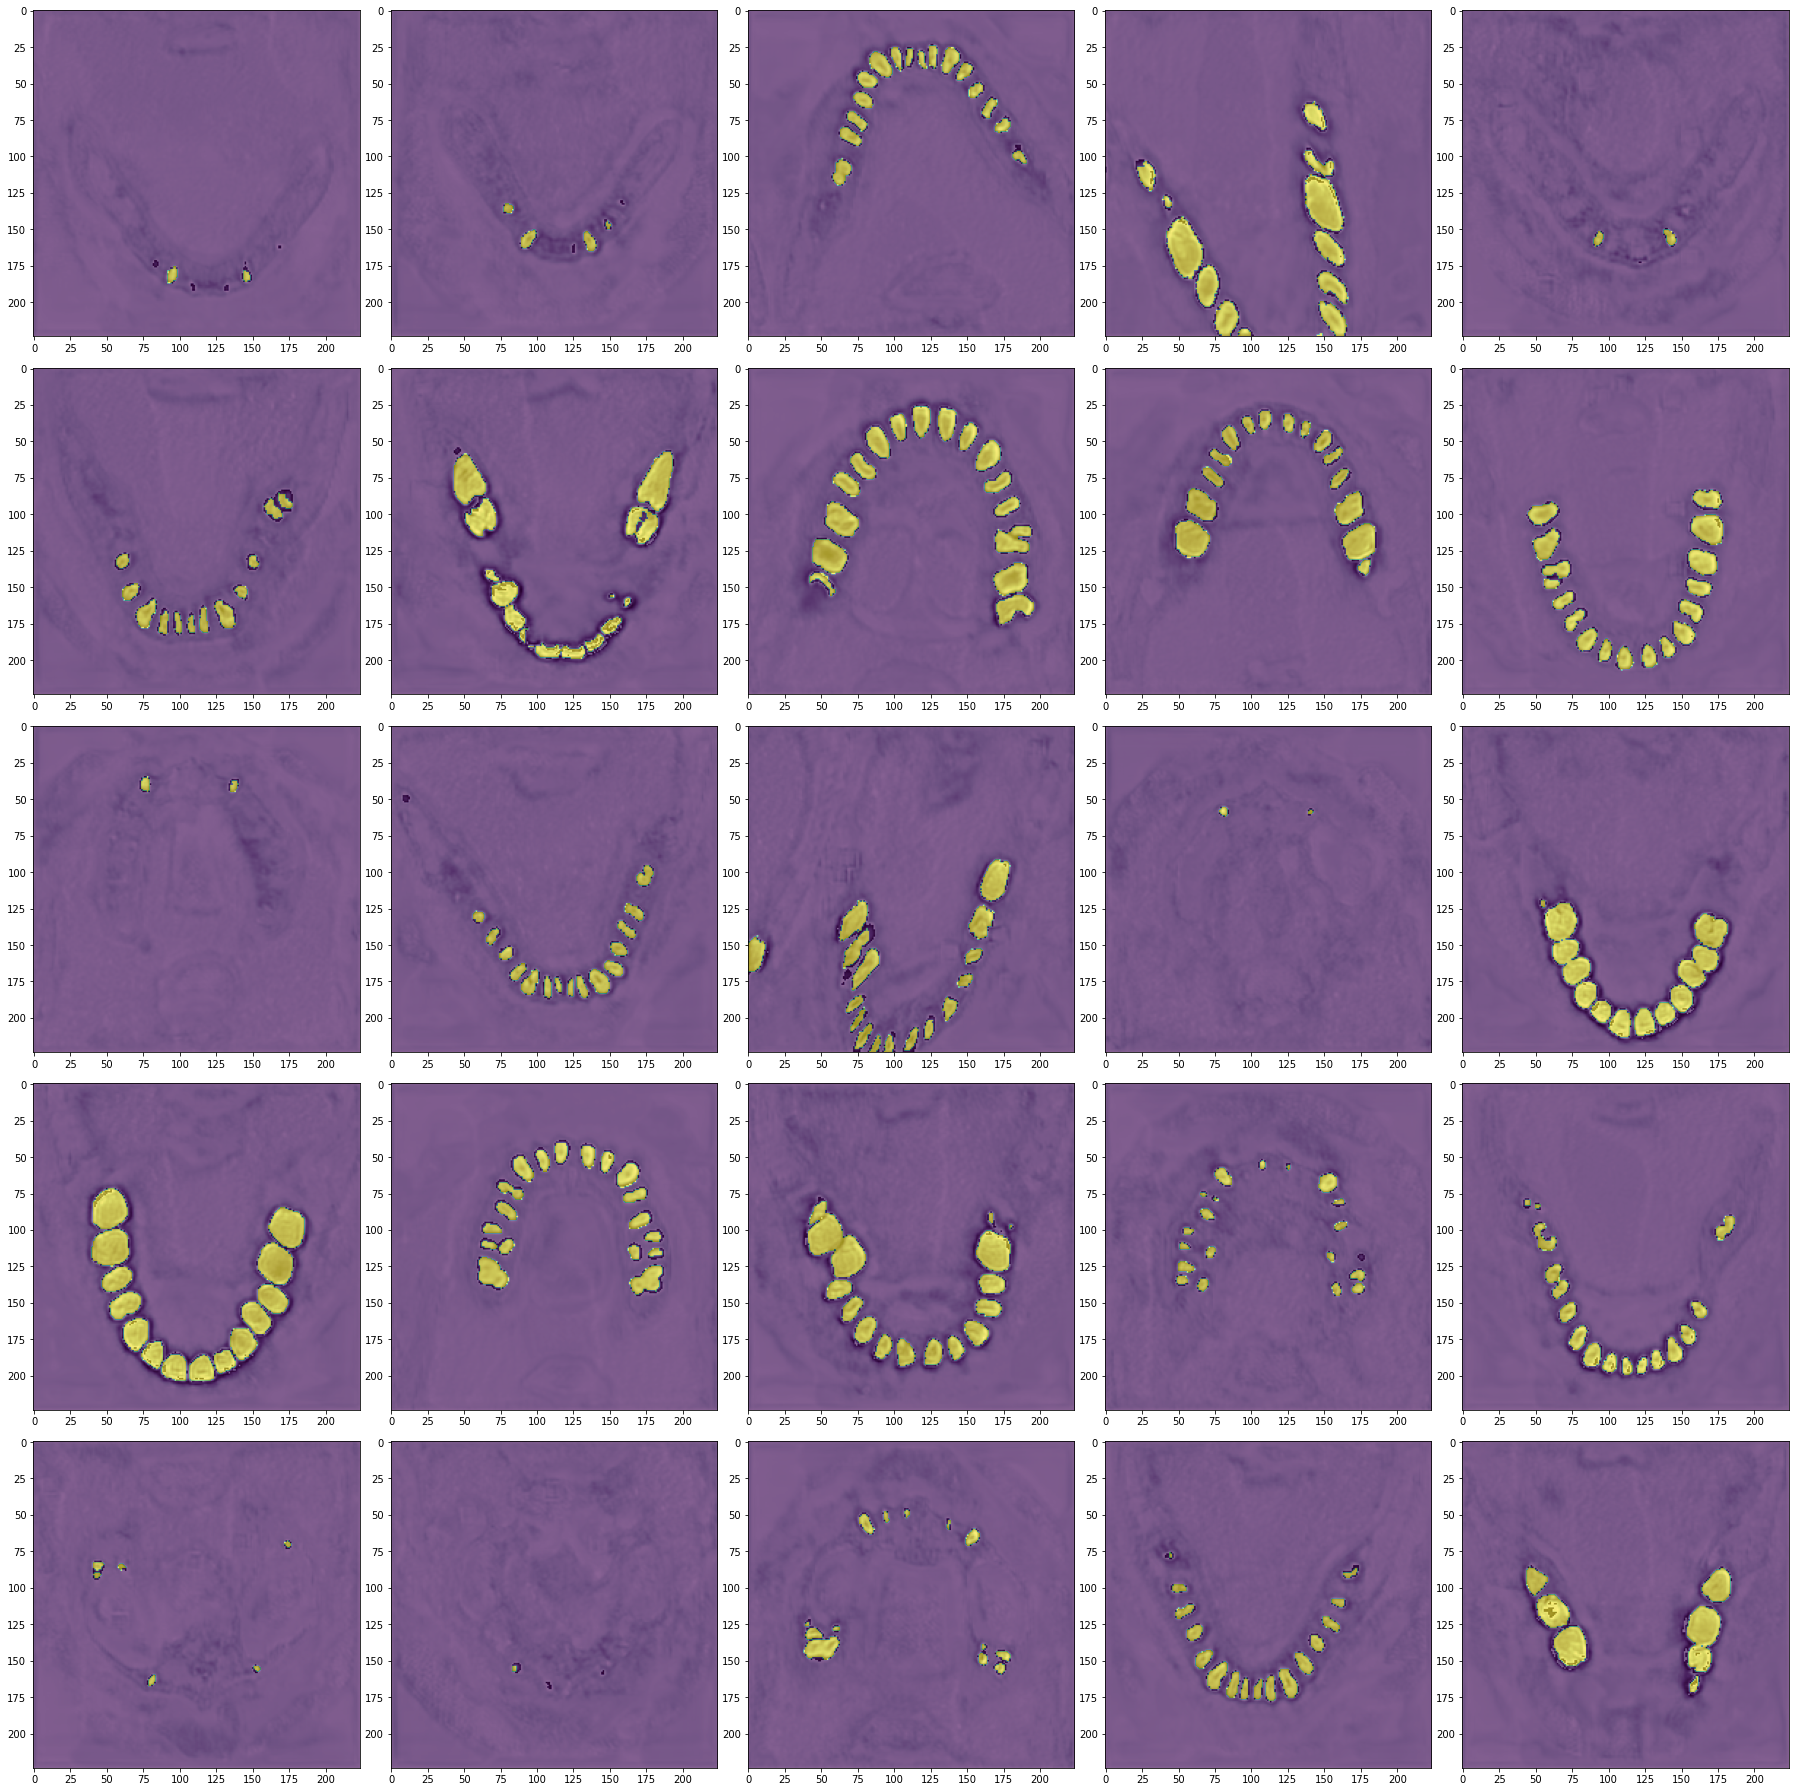

In [11]:
train_image, train_mask = next(iter(train_dataset_loader))
train_image = train_image.to(CFG.device, dtype=torch.float)
y_pred = model(train_image)
y_pred_1 = y_pred.cpu()
y_pred_2 = y_pred_1.detach().numpy()
train_image = train_image.cpu().detach().numpy()
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,]
        msk = msks[idx,].numpy()
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_batch(y_pred_2.squeeze(1).astype('uint8'), train_mask.squeeze(1), 25, 5)
torch.cuda.empty_cache()

img_path_list = os.listdir(img_path)
len_list = len(img_path_list)
img_path_list = img_path_list[round(0.8*len_list)+1:]
im_array = []
mask_array = []
for i in img_path_list:
    img_file = os.path.join(img_path,i)
    mask_file = os.path.join(mask_path,i)
    for j in tqdm(os.listdir(img_file)): 
        im = cv2.resize(cv2.imread(os.path.join(img_file,j)),(CFG.img_size[0],CFG.img_size[1]))[:,:,0]
        mask = cv2.resize(cv2.imread(os.path.join(mask_file,j)),(CFG.img_size[0],CFG.img_size[1]))[:,:,0]
        im_array.append(im)
        mask_array.append(mask)
test_images = torch.from_numpy(np.array(im_array))
test_masks = torch.from_numpy(np.array(mask_array))
test_images = test_images.to(CFG.device, dtype=torch.float)
with torch.no_grad():
    preds = model(test_images.unsqueeze(1)).squeeze(1)
    preds = preds.cpu().detach().numpy()
    
test_dataset = BuildDataset(img_path, mask_path,"test",data_transforms)
test_dataset_loader = DataLoader(train_dataset, batch_size=5, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
test_images, test_masks = next(iter(test_dataset_loader))
test_images = test_images.to(CFG.device, dtype=torch.float)
test_masks = test_masks.to(CFG.device, dtype=torch.float).cpu().detach().numpy()
preds = []
#model = build_model()
#model.load_state_dict(torch.load(f"best_epoch-{fold:02d}.bin")).eval()
with torch.no_grad():
    preds = model(test_images).squeeze(1)
    preds = preds.cpu().detach().numpy()
    
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,]
        img = img.astype('uint8')
        msk = msks[idx,]
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_batch(preds, test_masks, 5, 5)

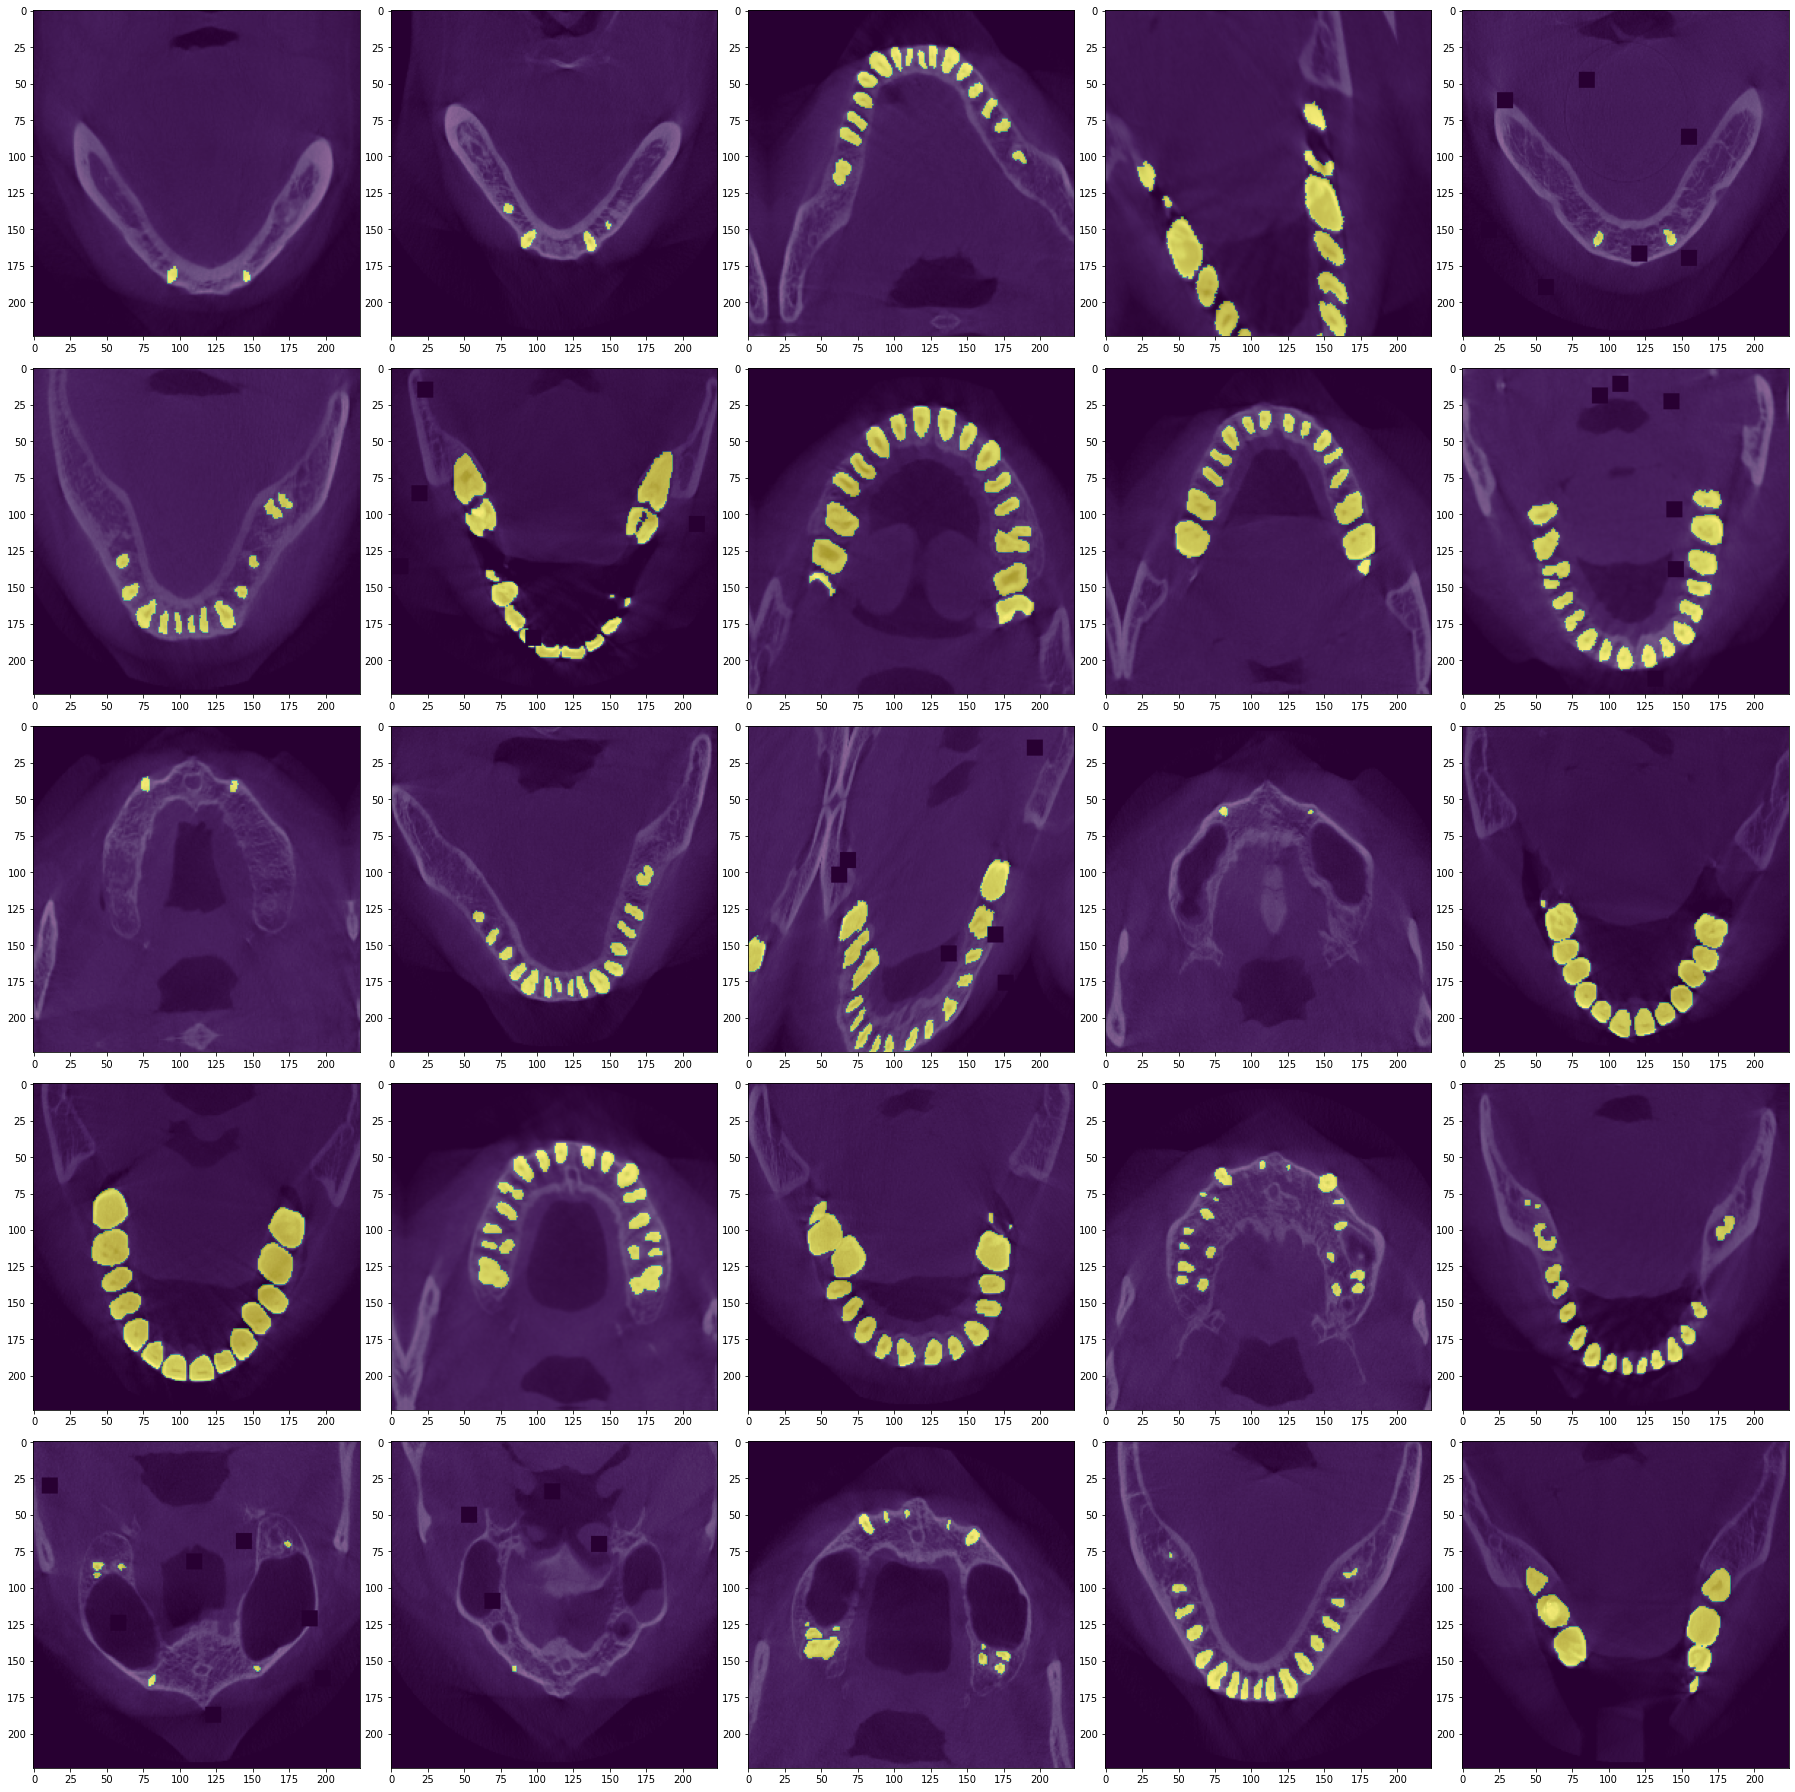

In [12]:
plot_batch(train_image.squeeze(1).astype('uint8'), train_mask.squeeze(1), 25, 5)